In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import os
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import pycountry_convert as pc
import folium 
from datetime import datetime
from datetime import timedelta


import matplotlib.pyplot as plt
plt.style.use('seaborn-white') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
import matplotlib.dates as mdate
pio.templates.default = "plotly_dark"

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.manual_seed(0)
np.random.seed(0)
# torch.cuda.set_device(3)



In [2]:
def error_mse(ty, py):
    mse = mean_squared_error(ty, py)
    return mse

def error_rmsle(ty, py):
    rmsle = np.sqrt(mean_squared_log_error(ty, py))
    return rmsle

def error_mae(ty, py):
    mae = mean_absolute_error(ty, py)
    return mae

def error_mape(ty, py):
    mape = np.mean(np.abs((py - ty) / ty)) 
    return mape

def error_rmse(ty, py):
    mse = mean_squared_error(ty, py)    
    rmse = np.sqrt(mse)
    return rmse

In [9]:
# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)

input_window = 50 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 100 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
          
class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.05):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

def _log2(data):
    return np.exp(np.exp(data))
    
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw, ganData = None):
    inout_seq = []
    inout_seq.extend(create_inout_sequences_front(input_data, tw))
    inout_seq.extend(create_inout_sequences_back(input_data, tw))
    if ganData is not None:
        inout_seq.extend(create_train_sequences(ganData, tw))
    return torch.FloatTensor(inout_seq)

def create_train_sequences(input_data, tw):
    inout_seq = []
    input_data = input_data.reshape(input_data.shape[0], input_data.shape[1])
    for i in range(input_data.shape[0]):
        train_seq = input_data[i][0:tw]
        train_label = input_data[i][1:tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    
def create_inout_sequences_front(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def create_inout_sequences_back(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(tw, L, 1):
        train_seq = input_data[i - tw : i ]
        train_label = input_data[i - tw + output_window : i + output_window]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def log2_(df):
    df = df[df["confirmed"] >= 3]
    df = df[df["fatalities"] >= 3]
    df["confirmed"] = np.log(np.log(df["confirmed"]))
    df["fatalities"] = np.log(np.log(df["fatalities"]))
    idex = list(range(0, df.shape[0]))
    df["day"] = idex
    return df

def addCsv(df): #累加
    temp_df = df.copy()
    #  ->   2021/4/29新加入代码
#     temp_df = temp_df[temp_df["confirmed"] >= 1]
#     temp_df = temp_df[temp_df["fatalities"] >= 1]
    #  <-  2021/4/29新加入代码
    confirmed_ = np.array(temp_df['confirmed'].astype(np.float32)).reshape(-1, 1)
    fatalities_ = np.array(temp_df['fatalities'].astype(np.float32)).reshape(-1, 1)
    for i in range(confirmed_.shape[0] - 1):
        confirmed_[i+1] += confirmed_[i]
    for i in range(fatalities_.shape[0] - 1):
        fatalities_[i+1] += fatalities_[i]    
    temp_df['confirmed'] = confirmed_
    temp_df['fatalities'] = fatalities_
    return temp_df

from sklearn.preprocessing import StandardScaler
class DealData:
    def __init__(self, truthName, ganName = None):
        self.scaler = StandardScaler()  #'/home/soul/NewWorkSpace/Informer2020CP/data/ETT/global.csv'
        self.amplitude = pd.read_csv(truthName)
        self.amplitude = addCsv(self.amplitude)  ## 处理累加
        self.amplitude =  np.array(self.amplitude['fatalities'].astype(np.float32))
        
        self.scaler.fit(self.amplitude.reshape(-1, 1))
        self.amplitude = self.scaler.transform(self.amplitude.reshape(-1, 1)).reshape(-1)
        #         _del30_confirmed_SJ_noise_61_1000
        #/home/soul/NewWorkSpace/Covid_2021_4_18/ganData/stand_global_+_del30_confirmed_noise_61_1000.npy
        if ganName is not None:
            self.trainData = np.load(ganName)
        else:
            self.trainData = None
        
    def trainTestData(self):
        train_sampels = -30
        test_samples = -80
        train_data = self.amplitude[:train_sampels]
        test_data = self.amplitude[test_samples:]

        train_sequence = create_inout_sequences(train_data, input_window, self.trainData)
        test_sequenc = create_inout_sequences(test_data, input_window)
        
        return train_sequence.to(device),test_sequenc.to(device)
    
    def train_data(self):
        train_sequence = create_train_sequences(self.trainData, input_window, self.trainData)
        return train_sequence.to(device)
    
    def trainPredictData(self):
        self.trainData = np.load("/home/soul/NewWorkSpace/Covid_2021_4_18/ganData/stand_global_+_confirmed_noise_61_1000.npy")
        train_data = self.amplitude
        train_sequence = create_inout_sequences(train_data, input_window, self.trainData)
        return train_sequence.to(device)
    
    def get_plot_data(self, eval_model):
        eval_model.eval() 
        test_result = torch.Tensor(0)    
        truth = torch.Tensor(0)
        
        temp_data = torch.FloatTensor(self.amplitude[0:input_window])
        test_result = torch.cat((test_result, temp_data), 0)
        truth = torch.cat((truth, temp_data), 0)
        
        data_source = torch.FloatTensor(create_inout_sequences_back(self.amplitude, input_window)).to(device)
        with torch.no_grad():
            for i in range(0, len(data_source)):
                data, target = get_batch(data_source, i,1)
                output = eval_model(data)    
                test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
            mse   = error_mse(truth[-30:], test_result[-30:])
            rmsle = error_rmsle(truth[-30:], test_result[-30:])
            mae   = error_mae(truth[-30:], test_result[-30:])
            mape  = error_mape(truth[-30:].numpy(), test_result[-30:].numpy())
            rmse  = error_rmse(truth[-30:], test_result[-30:])
                
        print(len(test_result), len(truth))
        truth = self.scaler.inverse_transform(truth)
        test_result = self.scaler.inverse_transform(test_result)
        return mse, rmsle, mae, mape, rmse, truth, test_result

    
    def plot_and_loss(self, eval_model,epoch, test = False):
        eval_model.eval() 
        total_loss = 0.
        test_result = torch.Tensor(0)    
        truth = torch.Tensor(0)
        
        temp_data = torch.FloatTensor(self.amplitude[0:input_window])
        test_result = torch.cat((test_result, temp_data), 0)
        truth = torch.cat((truth, temp_data), 0)
        
        data_source = torch.FloatTensor(create_inout_sequences_back(self.amplitude, input_window)).to(device)
        with torch.no_grad():
            for i in range(0, len(data_source)):
                data, target = get_batch(data_source, i,1)
                output = eval_model(data)    
                test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
                
            mse = error_mse(truth[-30:], test_result[-30:])
            rmsle = error_rmsle(truth[-30:], test_result[-30:])
        
            if test == False:
                temp_truth = truth
                for t in range(0, 30):
                    data = np.array(temp_truth[-input_window:]).reshape([input_window, 1, 1]).astype(np.float32)
                    output = eval_model(torch.FloatTensor(data).to(device))   
                    temp_truth = torch.cat((temp_truth, output[-1].view(-1).cpu()), 0)
                    test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                
        print(len(test_result), len(truth))
        truth = self.scaler.inverse_transform(truth)
        test_result = self.scaler.inverse_transform(test_result)
        
        fig = pyplot.figure(figsize=[20, 10])
        pyplot.title('Global Confirmed Data')
        pyplot.plot(truth[-100:], color='blue', marker='o')
        pyplot.plot(truth[-100:],color="blue", label = 'Measured')
        
        if test == False:
            pyplot.plot(test_result[-130:], color='green', marker='o')
            pyplot.plot(test_result[-130:], color="green", label = 'Predicted')

            pyplot.plot(test_result[-130:-30], color='red', marker='o')
            pyplot.plot(test_result[-130:-30], color="red", label = 'Predicted')        
        else:
            pyplot.plot(test_result[-100:], color='green', marker='o')
            pyplot.plot(test_result[-100:], color="green", label = 'Predicted')

            pyplot.plot(test_result[-100:-30], color='red', marker='o')
            pyplot.plot(test_result[-100:-30], color="red", label = 'Predicted')
        pyplot.show()
        pyplot.close()
        
        
        pyplot.title('Global Confirmed Data')
        pyplot.plot(test_result,color="green", label = 'Predicted')
        pyplot.plot(test_result[:-30],color="red", label = 'Predicted')
        pyplot.plot(truth,color="blue", label = 'Measured')
        pyplot.grid(True)
        pyplot.legend(loc='best')
    #     pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
        pyplot.show()
        pyplot.close()
        
        return mse, rmsle


def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - i) #len(source) - 1 - i
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()
    a = output_window / input_window
    b = 1 - a
    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
#         loss = criterion(output, targets)
        loss = criterion(output[-output_window:], targets[-output_window:])
#         loss =  a * criterion(output[:-output_window], targets[:-output_window]) + b * criterion(output[-output_window:], targets[-output_window:])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 10
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += criterion(output[-output_window:], targets[-output_window:]).cpu().item()
    return total_loss / len(data_source)


def saveModel(model, name):
    # 保存
    torch.save(model.state_dict(), './saveModel/' + name + '.pkl')

def loadModel(model, name):
    # 加载
    model.load_state_dict(torch.load('./saveModel/' + name + '.pkl'))
    return model


def save_epoch_data(epochs = 20):
    df = pd.DataFrame()
    df['X'] = []
    df['Y'] = []
    
    frames = []
    for i in range(epochs):
        model = TransAm().to(device)
        model = loadModel(model, "parameter_global_confirmed_50sq_del30_changeLoss_noise_" + str(i) + "_best")
        dealData = DealData()
        truths, predicts = dealData.get_plot_data(model)
    
        temp_df = pd.DataFrame()
        temp_df['X'] = range(len(predicts))
        temp_df['Y'] = predicts
        
        frames.append(temp_df)
        
    result = pd.concat(frames)
    result.to_csv("epoch_data_changLoss_noise_20.csv")

    
def plog_epoch_image(epochs = 20):
    
    df = pd.read_csv("epoch_data_changLoss_noise_20.csv")

    sns.lineplot(x="X", y="Y",color="red", ci="sd", data=df)
    
#     plt.plot(serise, truth[-100:], color='purple', marker='o')
#     plt.plot(serise, truth[-100:],color="purple", label = 'Reported')

#     plt.plot(serise, predict[-100:], color='orange', marker='o')
#     plt.plot(serise, predict[-100:], color="orange", label = 'Projection')

#     plt.plot(serise, predict[-100:-30], color='crimson', marker='o')
#     plt.plot(serise, predict[-100:-30], color="crimson", label = 'Fitting')


def plot_image(truth, predict, start = '2020-01-22', end = '2021-04-25', title = 'Global Fatality Data', isSave = False):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,1,1)
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#设置时间标签显示格式
    serise= pd.date_range(start, end)
    plt.xticks(pd.date_range(start, end, freq='30d'),rotation=45)
    plt.title(title)
    
    plt.plot(serise, truth,color="purple", linewidth=4.0, label = 'Reported')
    plt.plot(serise, predict, color="orange", linewidth=4.0, label = 'Projection')
    plt.plot(serise[:-30], predict[:-30], linewidth=4.0, color="crimson", label = 'Fitting')
    plt.grid(True, which='both')
    plt.legend(loc="best")
    
    if isSave == True:
        plt.savefig('./saveImage/fatality/' + title)
    plt.show()


In [10]:
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/India.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_india_del30_fatality_noise_1000.npy")
train_data, val_data = dealData.trainTestData()
print(train_data.shape, val_data.shape)

torch.Size([1662, 2, 50]) torch.Size([60, 2, 50])


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch   1 |     1/    6 batches | lr 0.005000 | 64.46 ms | loss 127.82865 | ppl 32755088167046377532842402839098586806727037078304980992.00
| epoch   1 |     2/    6 batches | lr 0.005000 | 25.97 ms | loss 0.32380 | ppl     1.38
| epoch   1 |     3/    6 batches | lr 0.005000 | 25.43 ms | loss 30.88146 | ppl 25801715481275.65
| epoch   1 |     4/    6 batches | lr 0.005000 | 30.68 ms | loss 6.22396 | ppl   504.70
| epoch   1 |     5/    6 batches | lr 0.005000 | 26.12 ms | loss 2.76987 | ppl    15.96
| epoch   1 |     6/    6 batches | lr 0.005000 | 25.83 ms | loss 0.97277 | ppl     2.65
| epoch   2 |     1/    6 batches | lr 0.004513 | 54.36 ms | loss 42.37796 | ppl 2538139652002945024.00
| epoch   2 |     2/    6 batches | lr 0.004513 | 27.20 ms | loss 0.48174 | ppl     1.62
| epoch   2 |     3/    6 batches | lr 0.004513 | 29.53 ms | loss 11.04975 | ppl 62928.18
| epoch   2 |     4/    6 batches | lr 0.004513 | 29.26 ms | loss 3.50825 | ppl    33.39
| epoch   2 |     5/    6 batch

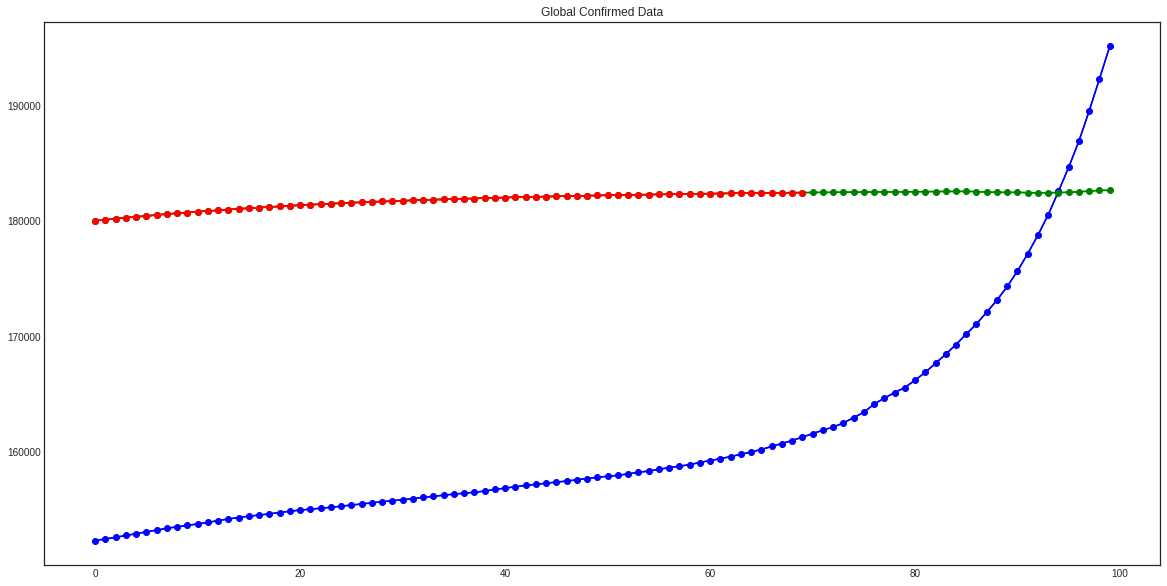

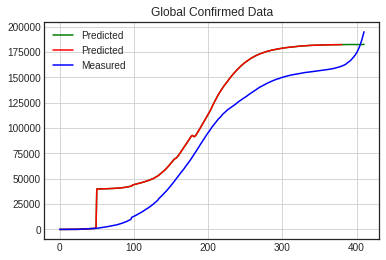

-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  3.00s | mse loss 0.04531 | rmsle loss 0.09054 
-----------------------------------------------------------------------------------------
| epoch  11 |     1/    6 batches | lr 0.002844 | 52.89 ms | loss 0.37243 | ppl     1.45
| epoch  11 |     2/    6 batches | lr 0.002844 | 30.20 ms | loss 0.07375 | ppl     1.08
| epoch  11 |     3/    6 batches | lr 0.002844 | 25.85 ms | loss 0.16258 | ppl     1.18
| epoch  11 |     4/    6 batches | lr 0.002844 | 32.07 ms | loss 0.01579 | ppl     1.02
| epoch  11 |     5/    6 batches | lr 0.002844 | 30.59 ms | loss 0.07566 | ppl     1.08


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  11 |     6/    6 batches | lr 0.002844 | 34.35 ms | loss 0.18904 | ppl     1.21
| epoch  12 |     1/    6 batches | lr 0.002702 | 51.38 ms | loss 0.19568 | ppl     1.22
| epoch  12 |     2/    6 batches | lr 0.002702 | 25.41 ms | loss 0.06759 | ppl     1.07
| epoch  12 |     3/    6 batches | lr 0.002702 | 28.43 ms | loss 0.01714 | ppl     1.02
| epoch  12 |     4/    6 batches | lr 0.002702 | 25.17 ms | loss 0.01533 | ppl     1.02
| epoch  12 |     5/    6 batches | lr 0.002702 | 25.21 ms | loss 0.10955 | ppl     1.12
| epoch  12 |     6/    6 batches | lr 0.002702 | 23.73 ms | loss 0.11052 | ppl     1.12
| epoch  13 |     1/    6 batches | lr 0.002567 | 52.55 ms | loss 0.28329 | ppl     1.33
| epoch  13 |     2/    6 batches | lr 0.002567 | 25.36 ms | loss 0.14321 | ppl     1.15
| epoch  13 |     3/    6 batches | lr 0.002567 | 27.16 ms | loss 0.07251 | ppl     1.08
| epoch  13 |     4/    6 batches | lr 0.002567 | 26.58 ms | loss 0.00397 | ppl     1.00
| epoch  13 |     5/ 

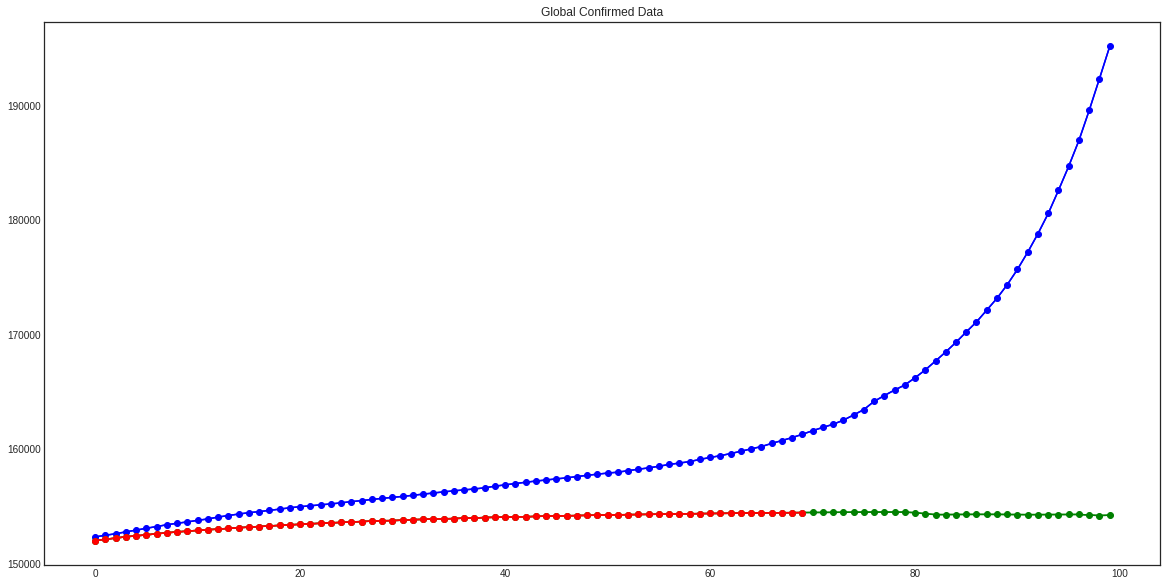

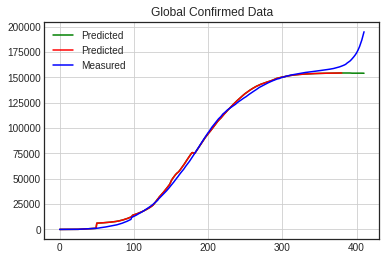

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  2.85s | mse loss 0.10091 | rmsle loss 0.14141 
-----------------------------------------------------------------------------------------
| epoch  21 |     1/    6 batches | lr 0.001703 | 49.87 ms | loss 0.01048 | ppl     1.01
| epoch  21 |     2/    6 batches | lr 0.001703 | 24.30 ms | loss 0.00302 | ppl     1.00
| epoch  21 |     3/    6 batches | lr 0.001703 | 24.78 ms | loss 0.00622 | ppl     1.01
| epoch  21 |     4/    6 batches | lr 0.001703 | 25.12 ms | loss 0.00362 | ppl     1.00
| epoch  21 |     5/    6 batches | lr 0.001703 | 24.99 ms | loss 0.00311 | ppl     1.00
| epoch  21 |     6/    6 batches | lr 0.001703 | 25.48 ms | loss 0.00398 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  22 |     1/    6 batches | lr 0.001618 | 59.46 ms | loss 0.00686 | ppl     1.01
| epoch  22 |     2/    6 batches | lr 0.001618 | 24.17 ms | loss 0.00199 | ppl     1.00
| epoch  22 |     3/    6 batches | lr 0.001618 | 36.92 ms | loss 0.01112 | ppl     1.01
| epoch  22 |     4/    6 batches | lr 0.001618 | 25.57 ms | loss 0.00628 | ppl     1.01
| epoch  22 |     5/    6 batches | lr 0.001618 | 27.29 ms | loss 0.00236 | ppl     1.00
| epoch  22 |     6/    6 batches | lr 0.001618 | 25.85 ms | loss 0.00145 | ppl     1.00
| epoch  23 |     1/    6 batches | lr 0.001537 | 55.09 ms | loss 0.00449 | ppl     1.00
| epoch  23 |     2/    6 batches | lr 0.001537 | 24.53 ms | loss 0.00331 | ppl     1.00
| epoch  23 |     3/    6 batches | lr 0.001537 | 24.29 ms | loss 0.00303 | ppl     1.00
| epoch  23 |     4/    6 batches | lr 0.001537 | 25.15 ms | loss 0.00266 | ppl     1.00
| epoch  23 |     5/    6 batches | lr 0.001537 | 25.36 ms | loss 0.01269 | ppl     1.01
| epoch  23 |     6/ 

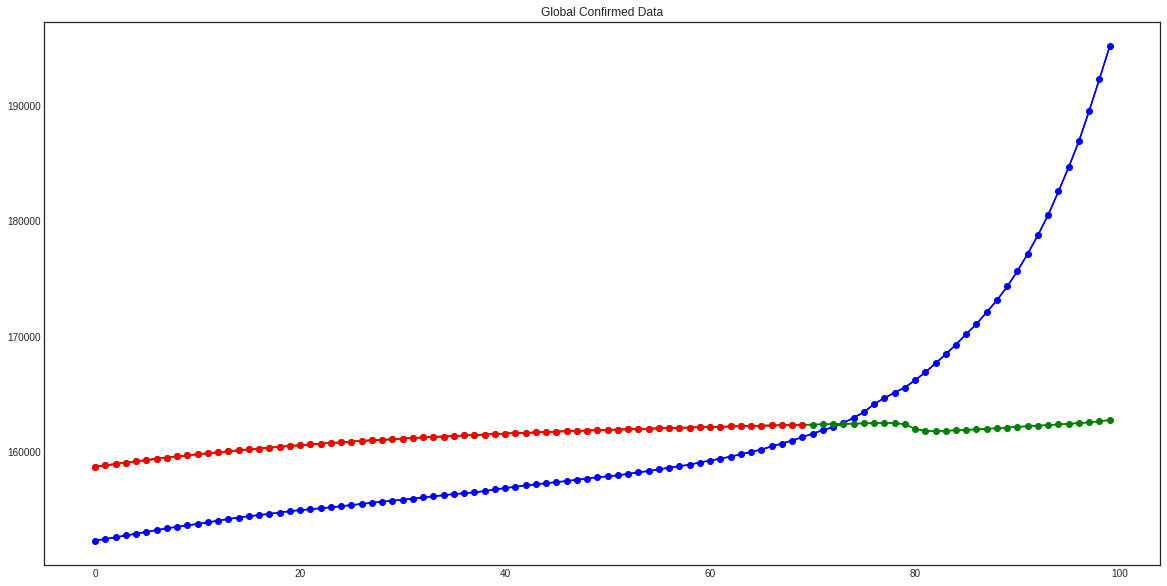

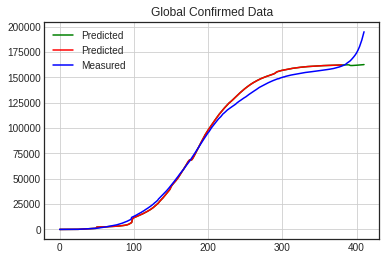

-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  2.88s | mse loss 0.04660 | rmsle loss 0.09229 
-----------------------------------------------------------------------------------------
| epoch  31 |     1/    6 batches | lr 0.001020 | 52.15 ms | loss 0.01410 | ppl     1.01
| epoch  31 |     2/    6 batches | lr 0.001020 | 35.55 ms | loss 0.04385 | ppl     1.04
| epoch  31 |     3/    6 batches | lr 0.001020 | 28.74 ms | loss 0.00907 | ppl     1.01
| epoch  31 |     4/    6 batches | lr 0.001020 | 25.34 ms | loss 0.00422 | ppl     1.00
| epoch  31 |     5/    6 batches | lr 0.001020 | 25.37 ms | loss 0.02287 | ppl     1.02
| epoch  31 |     6/    6 batches | lr 0.001020 | 23.78 ms | loss 0.00300 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  32 |     1/    6 batches | lr 0.000969 | 51.57 ms | loss 0.01288 | ppl     1.01
| epoch  32 |     2/    6 batches | lr 0.000969 | 26.24 ms | loss 0.01703 | ppl     1.02
| epoch  32 |     3/    6 batches | lr 0.000969 | 27.39 ms | loss 0.01445 | ppl     1.01
| epoch  32 |     4/    6 batches | lr 0.000969 | 31.12 ms | loss 0.00373 | ppl     1.00
| epoch  32 |     5/    6 batches | lr 0.000969 | 25.19 ms | loss 0.00553 | ppl     1.01
| epoch  32 |     6/    6 batches | lr 0.000969 | 23.74 ms | loss 0.00413 | ppl     1.00
| epoch  33 |     1/    6 batches | lr 0.000920 | 55.12 ms | loss 0.03721 | ppl     1.04
| epoch  33 |     2/    6 batches | lr 0.000920 | 25.75 ms | loss 0.03164 | ppl     1.03
| epoch  33 |     3/    6 batches | lr 0.000920 | 25.00 ms | loss 0.00828 | ppl     1.01
| epoch  33 |     4/    6 batches | lr 0.000920 | 25.11 ms | loss 0.00455 | ppl     1.00
| epoch  33 |     5/    6 batches | lr 0.000920 | 25.10 ms | loss 0.02214 | ppl     1.02
| epoch  33 |     6/ 

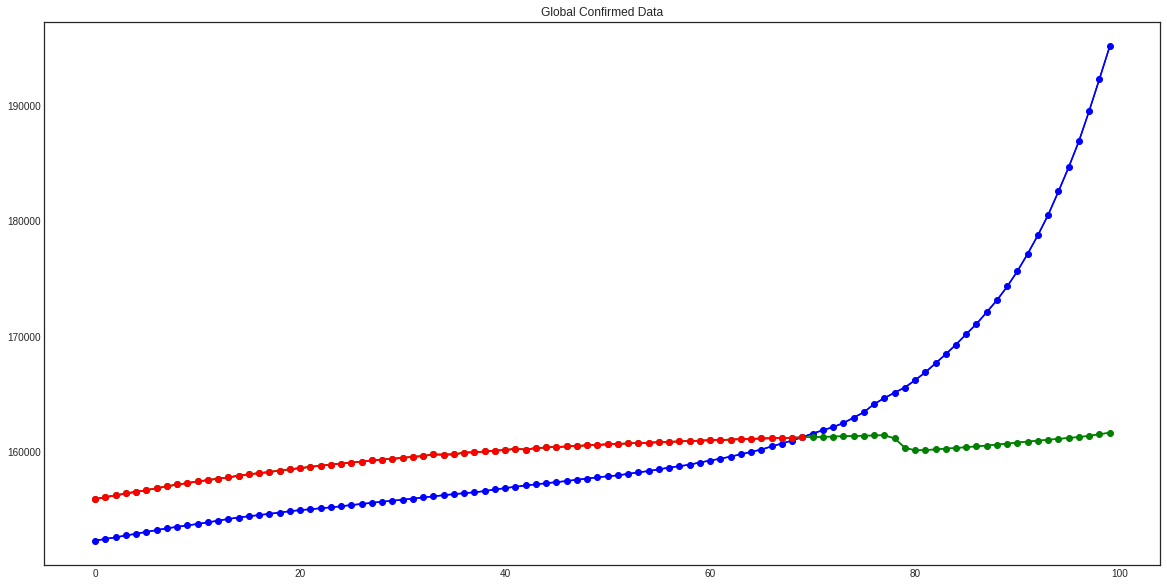

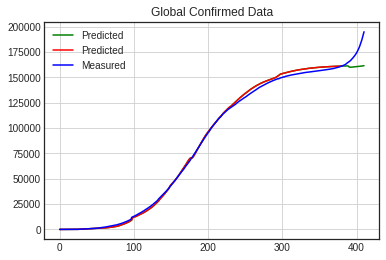

-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  2.85s | mse loss 0.05334 | rmsle loss 0.09942 
-----------------------------------------------------------------------------------------
| epoch  41 |     1/    6 batches | lr 0.000610 | 48.62 ms | loss 0.00353 | ppl     1.00
| epoch  41 |     2/    6 batches | lr 0.000610 | 25.41 ms | loss 0.00565 | ppl     1.01
| epoch  41 |     3/    6 batches | lr 0.000610 | 24.35 ms | loss 0.00213 | ppl     1.00
| epoch  41 |     4/    6 batches | lr 0.000610 | 24.29 ms | loss 0.00109 | ppl     1.00
| epoch  41 |     5/    6 batches | lr 0.000610 | 24.41 ms | loss 0.00201 | ppl     1.00
| epoch  41 |     6/    6 batches | lr 0.000610 | 22.81 ms | loss 0.00251 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  42 |     1/    6 batches | lr 0.000580 | 48.92 ms | loss 0.00356 | ppl     1.00
| epoch  42 |     2/    6 batches | lr 0.000580 | 27.86 ms | loss 0.00155 | ppl     1.00
| epoch  42 |     3/    6 batches | lr 0.000580 | 26.15 ms | loss 0.00357 | ppl     1.00
| epoch  42 |     4/    6 batches | lr 0.000580 | 24.29 ms | loss 0.00131 | ppl     1.00
| epoch  42 |     5/    6 batches | lr 0.000580 | 23.92 ms | loss 0.00157 | ppl     1.00
| epoch  42 |     6/    6 batches | lr 0.000580 | 29.95 ms | loss 0.00268 | ppl     1.00
| epoch  43 |     1/    6 batches | lr 0.000551 | 58.79 ms | loss 0.00285 | ppl     1.00
| epoch  43 |     2/    6 batches | lr 0.000551 | 25.46 ms | loss 0.00212 | ppl     1.00
| epoch  43 |     3/    6 batches | lr 0.000551 | 23.92 ms | loss 0.00128 | ppl     1.00
| epoch  43 |     4/    6 batches | lr 0.000551 | 23.89 ms | loss 0.00085 | ppl     1.00
| epoch  43 |     5/    6 batches | lr 0.000551 | 23.87 ms | loss 0.00142 | ppl     1.00
| epoch  43 |     6/ 

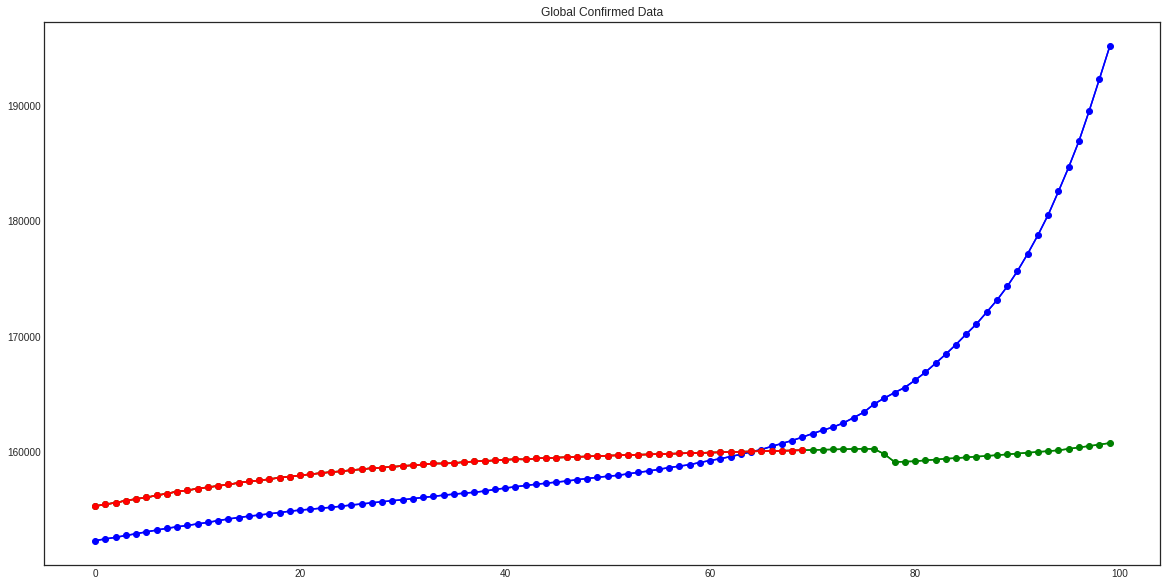

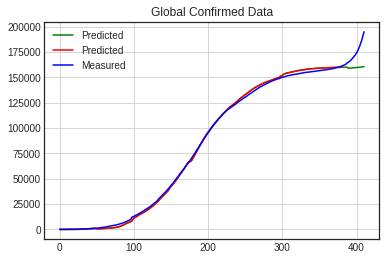

-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  2.77s | mse loss 0.05885 | rmsle loss 0.10495 
-----------------------------------------------------------------------------------------
| epoch  51 |     1/    6 batches | lr 0.000365 | 54.81 ms | loss 0.00155 | ppl     1.00
| epoch  51 |     2/    6 batches | lr 0.000365 | 34.68 ms | loss 0.00163 | ppl     1.00
| epoch  51 |     3/    6 batches | lr 0.000365 | 29.86 ms | loss 0.00159 | ppl     1.00
| epoch  51 |     4/    6 batches | lr 0.000365 | 29.23 ms | loss 0.00081 | ppl     1.00
| epoch  51 |     5/    6 batches | lr 0.000365 | 24.43 ms | loss 0.00116 | ppl     1.00
| epoch  51 |     6/    6 batches | lr 0.000365 | 23.18 ms | loss 0.00194 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  52 |     1/    6 batches | lr 0.000347 | 65.37 ms | loss 0.00216 | ppl     1.00
| epoch  52 |     2/    6 batches | lr 0.000347 | 23.71 ms | loss 0.00167 | ppl     1.00
| epoch  52 |     3/    6 batches | lr 0.000347 | 24.45 ms | loss 0.00160 | ppl     1.00
| epoch  52 |     4/    6 batches | lr 0.000347 | 24.31 ms | loss 0.00097 | ppl     1.00
| epoch  52 |     5/    6 batches | lr 0.000347 | 24.13 ms | loss 0.00113 | ppl     1.00
| epoch  52 |     6/    6 batches | lr 0.000347 | 22.83 ms | loss 0.00128 | ppl     1.00
| epoch  53 |     1/    6 batches | lr 0.000330 | 48.94 ms | loss 0.00202 | ppl     1.00
| epoch  53 |     2/    6 batches | lr 0.000330 | 24.27 ms | loss 0.00119 | ppl     1.00
| epoch  53 |     3/    6 batches | lr 0.000330 | 24.34 ms | loss 0.00148 | ppl     1.00
| epoch  53 |     4/    6 batches | lr 0.000330 | 24.31 ms | loss 0.00079 | ppl     1.00
| epoch  53 |     5/    6 batches | lr 0.000330 | 24.28 ms | loss 0.00114 | ppl     1.00
| epoch  53 |     6/ 

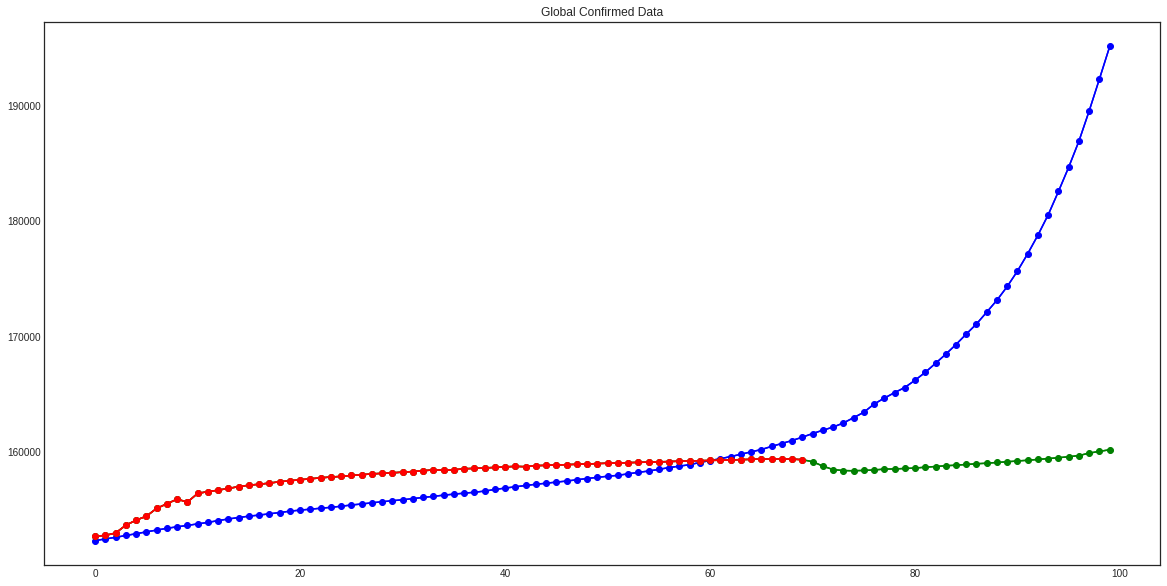

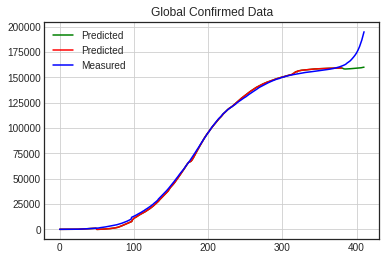

-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  2.80s | mse loss 0.06321 | rmsle loss 0.10921 
-----------------------------------------------------------------------------------------
| epoch  61 |     1/    6 batches | lr 0.000219 | 48.00 ms | loss 0.00195 | ppl     1.00
| epoch  61 |     2/    6 batches | lr 0.000219 | 24.21 ms | loss 0.00134 | ppl     1.00
| epoch  61 |     3/    6 batches | lr 0.000219 | 24.16 ms | loss 0.00156 | ppl     1.00
| epoch  61 |     4/    6 batches | lr 0.000219 | 24.11 ms | loss 0.00087 | ppl     1.00
| epoch  61 |     5/    6 batches | lr 0.000219 | 24.28 ms | loss 0.00107 | ppl     1.00
| epoch  61 |     6/    6 batches | lr 0.000219 | 36.21 ms | loss 0.00131 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  62 |     1/    6 batches | lr 0.000208 | 48.77 ms | loss 0.00179 | ppl     1.00
| epoch  62 |     2/    6 batches | lr 0.000208 | 24.47 ms | loss 0.00155 | ppl     1.00
| epoch  62 |     3/    6 batches | lr 0.000208 | 23.92 ms | loss 0.00120 | ppl     1.00
| epoch  62 |     4/    6 batches | lr 0.000208 | 25.03 ms | loss 0.00064 | ppl     1.00
| epoch  62 |     5/    6 batches | lr 0.000208 | 24.04 ms | loss 0.00106 | ppl     1.00
| epoch  62 |     6/    6 batches | lr 0.000208 | 25.11 ms | loss 0.00170 | ppl     1.00
| epoch  63 |     1/    6 batches | lr 0.000197 | 50.73 ms | loss 0.00169 | ppl     1.00
| epoch  63 |     2/    6 batches | lr 0.000197 | 29.77 ms | loss 0.00153 | ppl     1.00
| epoch  63 |     3/    6 batches | lr 0.000197 | 23.89 ms | loss 0.00197 | ppl     1.00
| epoch  63 |     4/    6 batches | lr 0.000197 | 24.32 ms | loss 0.00067 | ppl     1.00
| epoch  63 |     5/    6 batches | lr 0.000197 | 27.08 ms | loss 0.00085 | ppl     1.00
| epoch  63 |     6/ 

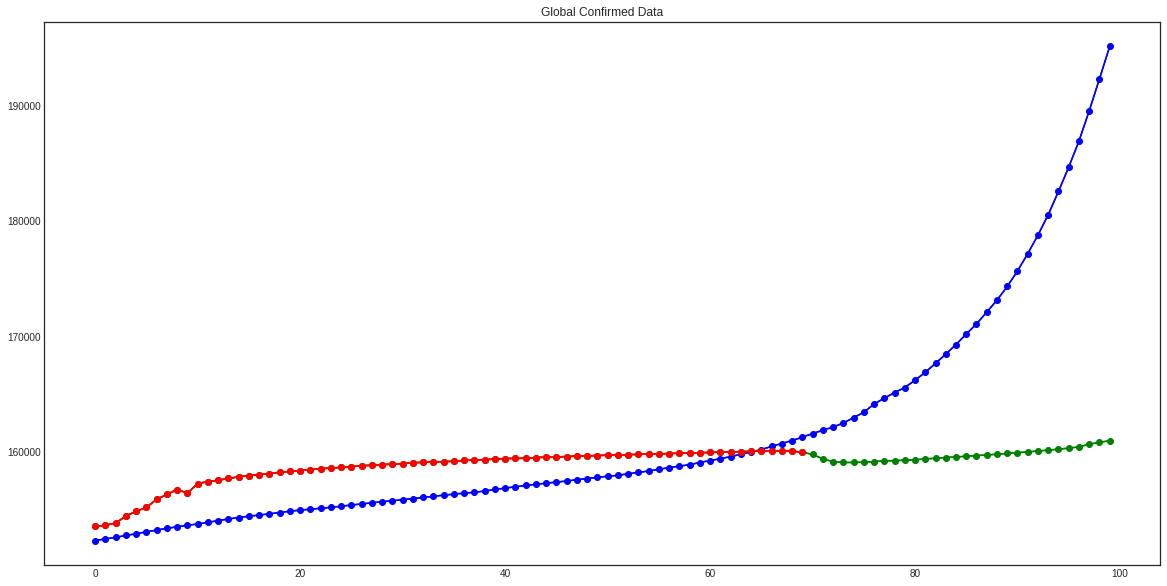

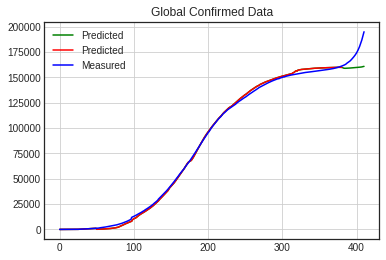

-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  2.81s | mse loss 0.05860 | rmsle loss 0.10474 
-----------------------------------------------------------------------------------------
| epoch  71 |     1/    6 batches | lr 0.000131 | 51.57 ms | loss 0.00198 | ppl     1.00
| epoch  71 |     2/    6 batches | lr 0.000131 | 24.58 ms | loss 0.00122 | ppl     1.00
| epoch  71 |     3/    6 batches | lr 0.000131 | 24.01 ms | loss 0.00167 | ppl     1.00
| epoch  71 |     4/    6 batches | lr 0.000131 | 24.28 ms | loss 0.00072 | ppl     1.00
| epoch  71 |     5/    6 batches | lr 0.000131 | 24.34 ms | loss 0.00100 | ppl     1.00
| epoch  71 |     6/    6 batches | lr 0.000131 | 32.50 ms | loss 0.00151 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  72 |     1/    6 batches | lr 0.000124 | 49.59 ms | loss 0.00194 | ppl     1.00
| epoch  72 |     2/    6 batches | lr 0.000124 | 25.16 ms | loss 0.00175 | ppl     1.00
| epoch  72 |     3/    6 batches | lr 0.000124 | 23.98 ms | loss 0.00209 | ppl     1.00
| epoch  72 |     4/    6 batches | lr 0.000124 | 31.71 ms | loss 0.00081 | ppl     1.00
| epoch  72 |     5/    6 batches | lr 0.000124 | 24.55 ms | loss 0.00104 | ppl     1.00
| epoch  72 |     6/    6 batches | lr 0.000124 | 22.51 ms | loss 0.00202 | ppl     1.00
| epoch  73 |     1/    6 batches | lr 0.000118 | 55.18 ms | loss 0.00176 | ppl     1.00
| epoch  73 |     2/    6 batches | lr 0.000118 | 25.42 ms | loss 0.00144 | ppl     1.00
| epoch  73 |     3/    6 batches | lr 0.000118 | 29.19 ms | loss 0.00156 | ppl     1.00
| epoch  73 |     4/    6 batches | lr 0.000118 | 25.45 ms | loss 0.00099 | ppl     1.00
| epoch  73 |     5/    6 batches | lr 0.000118 | 24.14 ms | loss 0.00112 | ppl     1.00
| epoch  73 |     6/ 

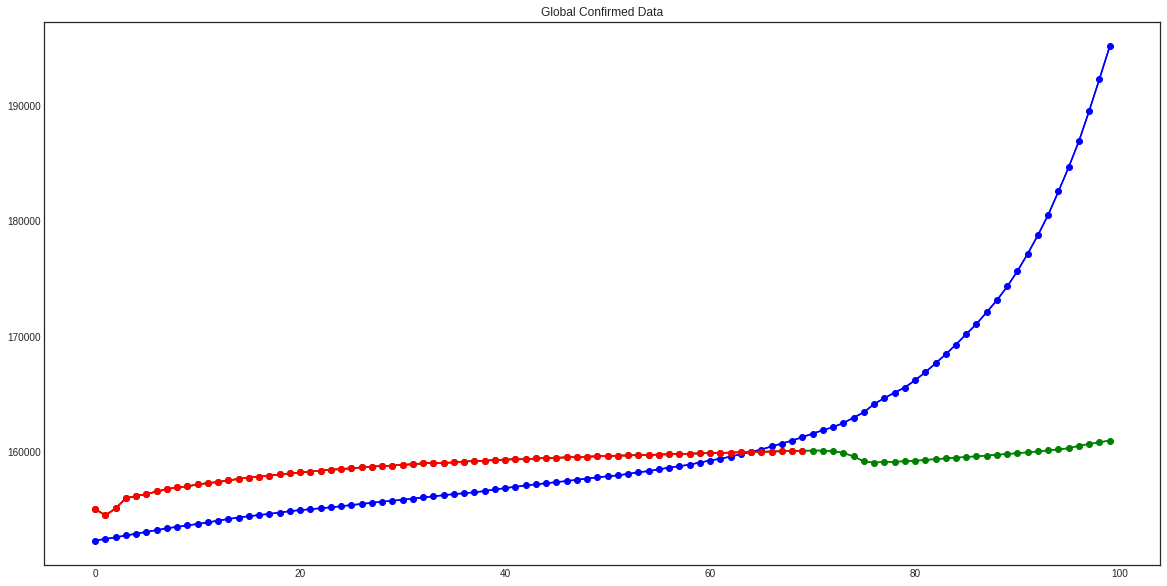

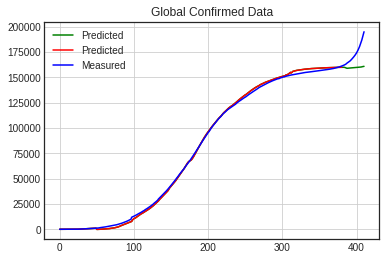

-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  2.80s | mse loss 0.05859 | rmsle loss 0.10473 
-----------------------------------------------------------------------------------------
| epoch  81 |     1/    6 batches | lr 0.000078 | 52.98 ms | loss 0.00181 | ppl     1.00
| epoch  81 |     2/    6 batches | lr 0.000078 | 24.31 ms | loss 0.00143 | ppl     1.00
| epoch  81 |     3/    6 batches | lr 0.000078 | 24.10 ms | loss 0.00143 | ppl     1.00
| epoch  81 |     4/    6 batches | lr 0.000078 | 24.28 ms | loss 0.00089 | ppl     1.00
| epoch  81 |     5/    6 batches | lr 0.000078 | 24.41 ms | loss 0.00108 | ppl     1.00
| epoch  81 |     6/    6 batches | lr 0.000078 | 22.64 ms | loss 0.00167 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  82 |     1/    6 batches | lr 0.000075 | 48.28 ms | loss 0.00188 | ppl     1.00
| epoch  82 |     2/    6 batches | lr 0.000075 | 24.19 ms | loss 0.00118 | ppl     1.00
| epoch  82 |     3/    6 batches | lr 0.000075 | 25.19 ms | loss 0.00158 | ppl     1.00
| epoch  82 |     4/    6 batches | lr 0.000075 | 31.77 ms | loss 0.00092 | ppl     1.00
| epoch  82 |     5/    6 batches | lr 0.000075 | 24.35 ms | loss 0.00107 | ppl     1.00
| epoch  82 |     6/    6 batches | lr 0.000075 | 22.63 ms | loss 0.00165 | ppl     1.00
| epoch  83 |     1/    6 batches | lr 0.000071 | 46.46 ms | loss 0.00193 | ppl     1.00
| epoch  83 |     2/    6 batches | lr 0.000071 | 24.09 ms | loss 0.00138 | ppl     1.00
| epoch  83 |     3/    6 batches | lr 0.000071 | 31.39 ms | loss 0.00165 | ppl     1.00
| epoch  83 |     4/    6 batches | lr 0.000071 | 24.35 ms | loss 0.00080 | ppl     1.00
| epoch  83 |     5/    6 batches | lr 0.000071 | 24.33 ms | loss 0.00089 | ppl     1.00
| epoch  83 |     6/ 

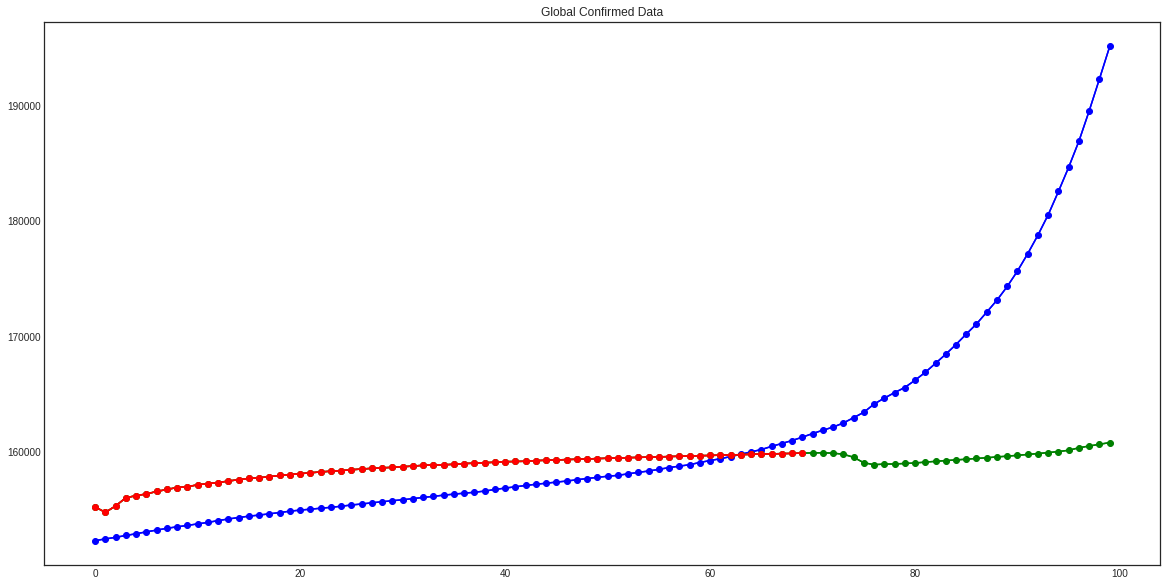

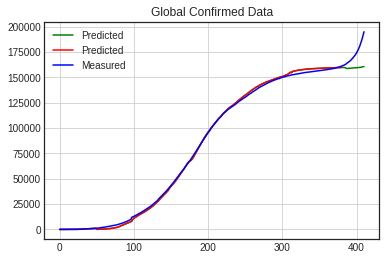

-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  2.85s | mse loss 0.05969 | rmsle loss 0.10581 
-----------------------------------------------------------------------------------------
| epoch  91 |     1/    6 batches | lr 0.000047 | 50.27 ms | loss 0.00187 | ppl     1.00
| epoch  91 |     2/    6 batches | lr 0.000047 | 30.53 ms | loss 0.00118 | ppl     1.00
| epoch  91 |     3/    6 batches | lr 0.000047 | 24.33 ms | loss 0.00126 | ppl     1.00
| epoch  91 |     4/    6 batches | lr 0.000047 | 24.45 ms | loss 0.00094 | ppl     1.00
| epoch  91 |     5/    6 batches | lr 0.000047 | 24.74 ms | loss 0.00105 | ppl     1.00
| epoch  91 |     6/    6 batches | lr 0.000047 | 32.55 ms | loss 0.00199 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  92 |     1/    6 batches | lr 0.000045 | 53.78 ms | loss 0.00156 | ppl     1.00
| epoch  92 |     2/    6 batches | lr 0.000045 | 26.95 ms | loss 0.00104 | ppl     1.00
| epoch  92 |     3/    6 batches | lr 0.000045 | 24.24 ms | loss 0.00160 | ppl     1.00
| epoch  92 |     4/    6 batches | lr 0.000045 | 24.07 ms | loss 0.00067 | ppl     1.00
| epoch  92 |     5/    6 batches | lr 0.000045 | 28.69 ms | loss 0.00094 | ppl     1.00
| epoch  92 |     6/    6 batches | lr 0.000045 | 22.76 ms | loss 0.00162 | ppl     1.00
| epoch  93 |     1/    6 batches | lr 0.000042 | 48.67 ms | loss 0.00204 | ppl     1.00
| epoch  93 |     2/    6 batches | lr 0.000042 | 24.98 ms | loss 0.00117 | ppl     1.00
| epoch  93 |     3/    6 batches | lr 0.000042 | 24.35 ms | loss 0.00124 | ppl     1.00
| epoch  93 |     4/    6 batches | lr 0.000042 | 24.13 ms | loss 0.00071 | ppl     1.00
| epoch  93 |     5/    6 batches | lr 0.000042 | 23.89 ms | loss 0.00093 | ppl     1.00
| epoch  93 |     6/ 

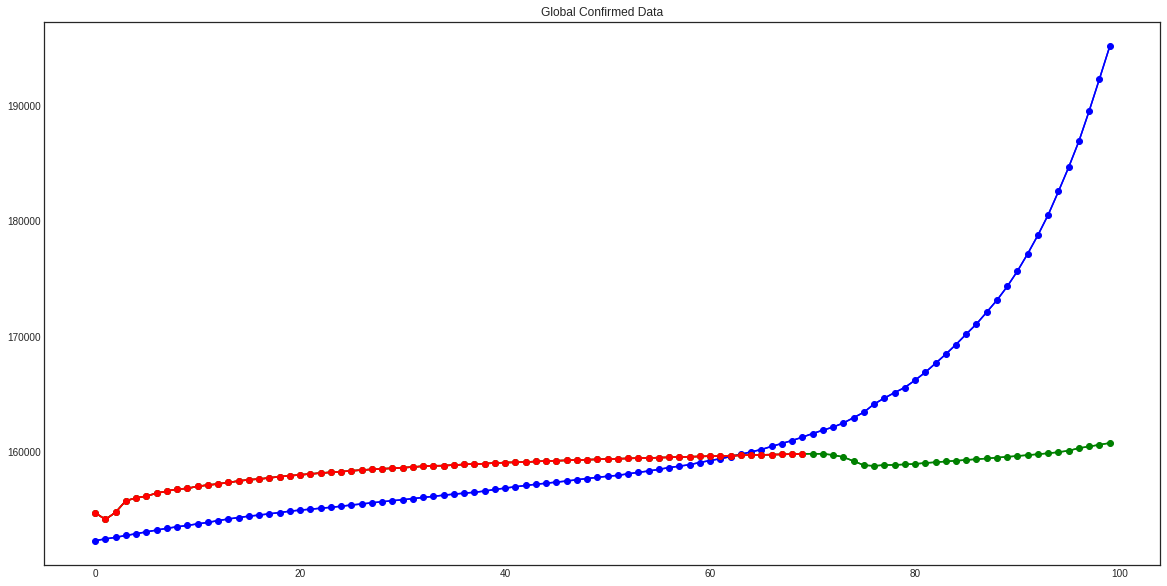

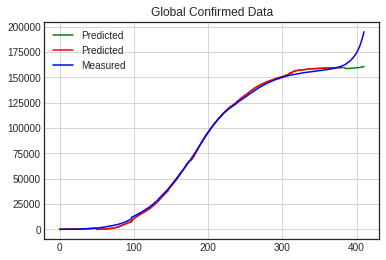

-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  2.84s | mse loss 0.06006 | rmsle loss 0.10617 
-----------------------------------------------------------------------------------------
| epoch 101 |     1/    6 batches | lr 0.000028 | 54.79 ms | loss 0.00165 | ppl     1.00
| epoch 101 |     2/    6 batches | lr 0.000028 | 24.88 ms | loss 0.00092 | ppl     1.00
| epoch 101 |     3/    6 batches | lr 0.000028 | 23.95 ms | loss 0.00155 | ppl     1.00
| epoch 101 |     4/    6 batches | lr 0.000028 | 24.23 ms | loss 0.00073 | ppl     1.00
| epoch 101 |     5/    6 batches | lr 0.000028 | 24.17 ms | loss 0.00108 | ppl     1.00
| epoch 101 |     6/    6 batches | lr 0.000028 | 22.74 ms | loss 0.00169 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 102 |     1/    6 batches | lr 0.000027 | 49.55 ms | loss 0.00152 | ppl     1.00
| epoch 102 |     2/    6 batches | lr 0.000027 | 24.43 ms | loss 0.00145 | ppl     1.00
| epoch 102 |     3/    6 batches | lr 0.000027 | 24.85 ms | loss 0.00143 | ppl     1.00
| epoch 102 |     4/    6 batches | lr 0.000027 | 29.18 ms | loss 0.00064 | ppl     1.00
| epoch 102 |     5/    6 batches | lr 0.000027 | 24.30 ms | loss 0.00104 | ppl     1.00
| epoch 102 |     6/    6 batches | lr 0.000027 | 22.57 ms | loss 0.00176 | ppl     1.00
| epoch 103 |     1/    6 batches | lr 0.000025 | 48.55 ms | loss 0.00184 | ppl     1.00
| epoch 103 |     2/    6 batches | lr 0.000025 | 33.17 ms | loss 0.00138 | ppl     1.00
| epoch 103 |     3/    6 batches | lr 0.000025 | 26.14 ms | loss 0.00132 | ppl     1.00
| epoch 103 |     4/    6 batches | lr 0.000025 | 23.93 ms | loss 0.00061 | ppl     1.00
| epoch 103 |     5/    6 batches | lr 0.000025 | 28.95 ms | loss 0.00117 | ppl     1.00
| epoch 103 |     6/ 

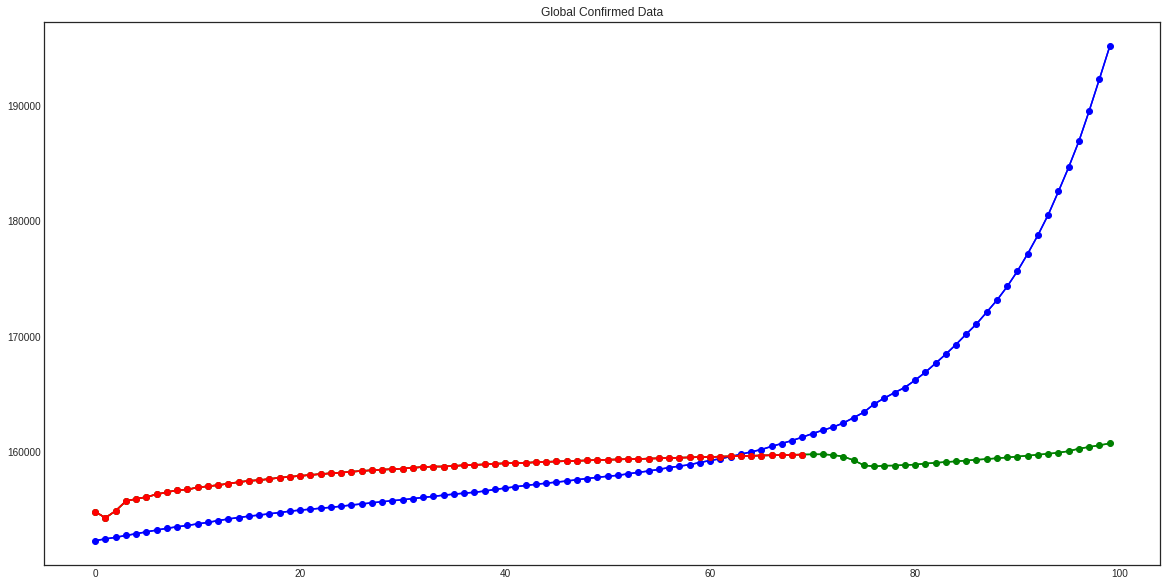

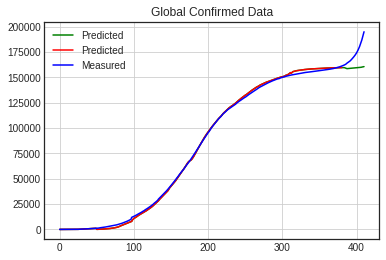

-----------------------------------------------------------------------------------------
| end of epoch 110 | time:  2.82s | mse loss 0.06033 | rmsle loss 0.10644 
-----------------------------------------------------------------------------------------
| epoch 111 |     1/    6 batches | lr 0.000017 | 48.52 ms | loss 0.00147 | ppl     1.00
| epoch 111 |     2/    6 batches | lr 0.000017 | 24.38 ms | loss 0.00101 | ppl     1.00
| epoch 111 |     3/    6 batches | lr 0.000017 | 24.08 ms | loss 0.00159 | ppl     1.00
| epoch 111 |     4/    6 batches | lr 0.000017 | 24.30 ms | loss 0.00094 | ppl     1.00
| epoch 111 |     5/    6 batches | lr 0.000017 | 24.19 ms | loss 0.00117 | ppl     1.00
| epoch 111 |     6/    6 batches | lr 0.000017 | 23.21 ms | loss 0.00136 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 112 |     1/    6 batches | lr 0.000016 | 49.09 ms | loss 0.00185 | ppl     1.00
| epoch 112 |     2/    6 batches | lr 0.000016 | 24.39 ms | loss 0.00127 | ppl     1.00
| epoch 112 |     3/    6 batches | lr 0.000016 | 24.93 ms | loss 0.00149 | ppl     1.00
| epoch 112 |     4/    6 batches | lr 0.000016 | 24.39 ms | loss 0.00100 | ppl     1.00
| epoch 112 |     5/    6 batches | lr 0.000016 | 24.39 ms | loss 0.00091 | ppl     1.00
| epoch 112 |     6/    6 batches | lr 0.000016 | 22.77 ms | loss 0.00180 | ppl     1.00
| epoch 113 |     1/    6 batches | lr 0.000015 | 49.69 ms | loss 0.00185 | ppl     1.00
| epoch 113 |     2/    6 batches | lr 0.000015 | 24.17 ms | loss 0.00142 | ppl     1.00
| epoch 113 |     3/    6 batches | lr 0.000015 | 24.91 ms | loss 0.00115 | ppl     1.00
| epoch 113 |     4/    6 batches | lr 0.000015 | 24.45 ms | loss 0.00086 | ppl     1.00
| epoch 113 |     5/    6 batches | lr 0.000015 | 24.33 ms | loss 0.00070 | ppl     1.00
| epoch 113 |     6/ 

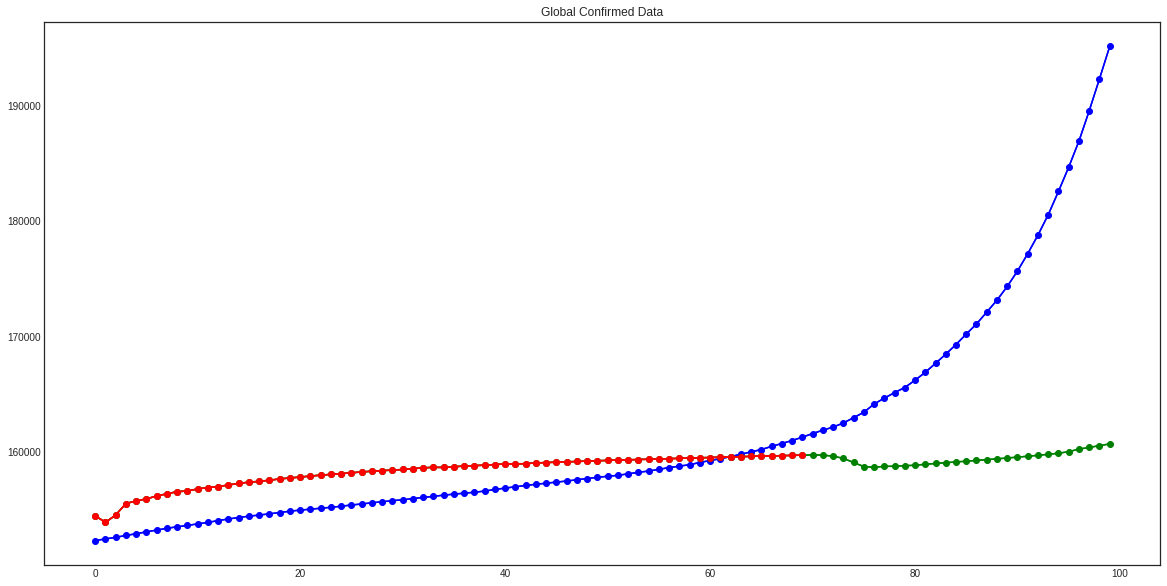

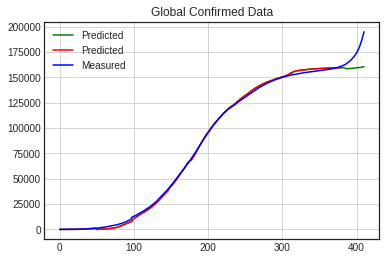

-----------------------------------------------------------------------------------------
| end of epoch 120 | time:  3.13s | mse loss 0.06065 | rmsle loss 0.10675 
-----------------------------------------------------------------------------------------
| epoch 121 |     1/    6 batches | lr 0.000010 | 66.06 ms | loss 0.00167 | ppl     1.00
| epoch 121 |     2/    6 batches | lr 0.000010 | 23.64 ms | loss 0.00110 | ppl     1.00
| epoch 121 |     3/    6 batches | lr 0.000010 | 28.10 ms | loss 0.00148 | ppl     1.00
| epoch 121 |     4/    6 batches | lr 0.000010 | 24.74 ms | loss 0.00074 | ppl     1.00
| epoch 121 |     5/    6 batches | lr 0.000010 | 24.45 ms | loss 0.00098 | ppl     1.00
| epoch 121 |     6/    6 batches | lr 0.000010 | 22.92 ms | loss 0.00185 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 122 |     1/    6 batches | lr 0.000010 | 65.24 ms | loss 0.00205 | ppl     1.00
| epoch 122 |     2/    6 batches | lr 0.000010 | 26.43 ms | loss 0.00113 | ppl     1.00
| epoch 122 |     3/    6 batches | lr 0.000010 | 24.13 ms | loss 0.00136 | ppl     1.00
| epoch 122 |     4/    6 batches | lr 0.000010 | 25.55 ms | loss 0.00092 | ppl     1.00
| epoch 122 |     5/    6 batches | lr 0.000010 | 24.17 ms | loss 0.00136 | ppl     1.00
| epoch 122 |     6/    6 batches | lr 0.000010 | 25.01 ms | loss 0.00168 | ppl     1.00
| epoch 123 |     1/    6 batches | lr 0.000009 | 48.76 ms | loss 0.00224 | ppl     1.00
| epoch 123 |     2/    6 batches | lr 0.000009 | 24.40 ms | loss 0.00139 | ppl     1.00
| epoch 123 |     3/    6 batches | lr 0.000009 | 24.46 ms | loss 0.00180 | ppl     1.00
| epoch 123 |     4/    6 batches | lr 0.000009 | 24.29 ms | loss 0.00074 | ppl     1.00
| epoch 123 |     5/    6 batches | lr 0.000009 | 24.33 ms | loss 0.00134 | ppl     1.00
| epoch 123 |     6/ 

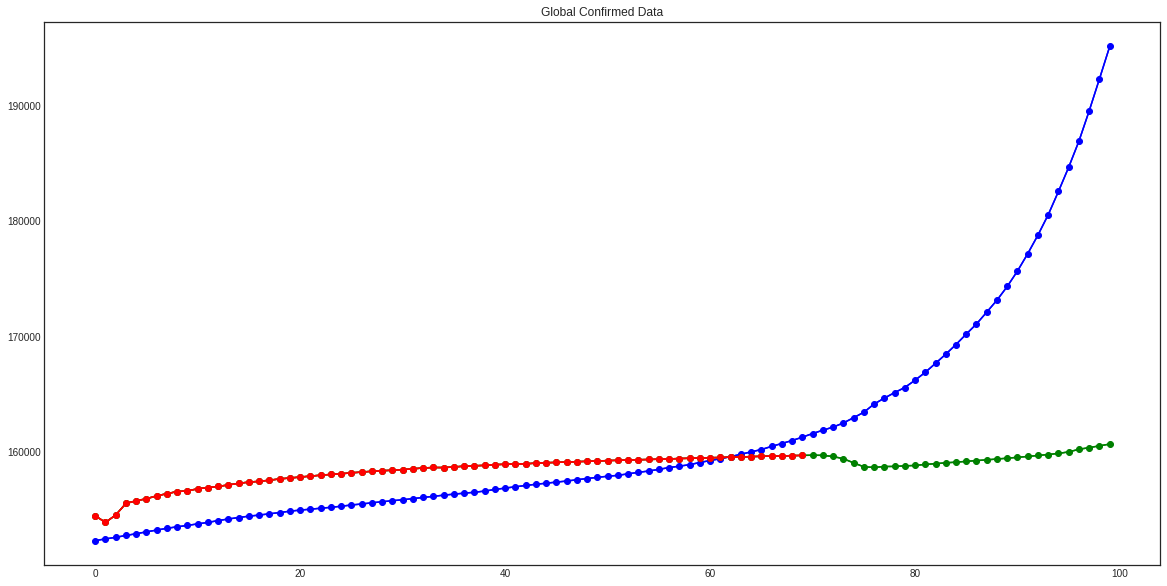

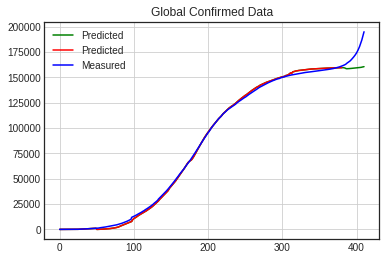

-----------------------------------------------------------------------------------------
| end of epoch 130 | time:  2.79s | mse loss 0.06075 | rmsle loss 0.10685 
-----------------------------------------------------------------------------------------
| epoch 131 |     1/    6 batches | lr 0.000006 | 49.51 ms | loss 0.00230 | ppl     1.00
| epoch 131 |     2/    6 batches | lr 0.000006 | 26.86 ms | loss 0.00134 | ppl     1.00
| epoch 131 |     3/    6 batches | lr 0.000006 | 24.36 ms | loss 0.00148 | ppl     1.00
| epoch 131 |     4/    6 batches | lr 0.000006 | 24.19 ms | loss 0.00065 | ppl     1.00
| epoch 131 |     5/    6 batches | lr 0.000006 | 24.23 ms | loss 0.00099 | ppl     1.00
| epoch 131 |     6/    6 batches | lr 0.000006 | 22.77 ms | loss 0.00161 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 132 |     1/    6 batches | lr 0.000006 | 49.52 ms | loss 0.00179 | ppl     1.00
| epoch 132 |     2/    6 batches | lr 0.000006 | 24.55 ms | loss 0.00097 | ppl     1.00
| epoch 132 |     3/    6 batches | lr 0.000006 | 24.83 ms | loss 0.00163 | ppl     1.00
| epoch 132 |     4/    6 batches | lr 0.000006 | 39.68 ms | loss 0.00076 | ppl     1.00
| epoch 132 |     5/    6 batches | lr 0.000006 | 25.17 ms | loss 0.00118 | ppl     1.00
| epoch 132 |     6/    6 batches | lr 0.000006 | 25.13 ms | loss 0.00086 | ppl     1.00
| epoch 133 |     1/    6 batches | lr 0.000005 | 49.41 ms | loss 0.00189 | ppl     1.00
| epoch 133 |     2/    6 batches | lr 0.000005 | 24.62 ms | loss 0.00110 | ppl     1.00
| epoch 133 |     3/    6 batches | lr 0.000005 | 24.65 ms | loss 0.00143 | ppl     1.00
| epoch 133 |     4/    6 batches | lr 0.000005 | 24.34 ms | loss 0.00073 | ppl     1.00
| epoch 133 |     5/    6 batches | lr 0.000005 | 24.33 ms | loss 0.00083 | ppl     1.00
| epoch 133 |     6/ 

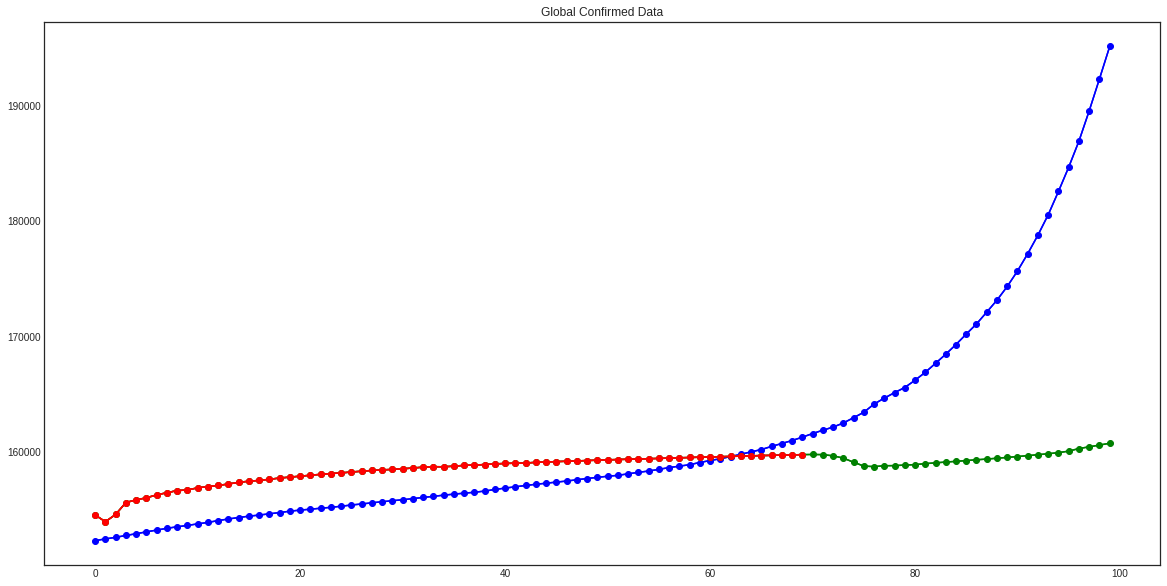

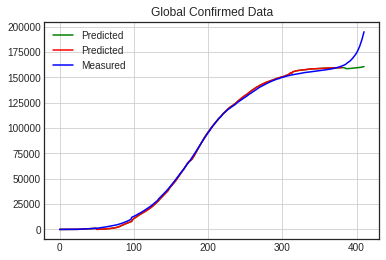

-----------------------------------------------------------------------------------------
| end of epoch 140 | time:  2.84s | mse loss 0.06033 | rmsle loss 0.10645 
-----------------------------------------------------------------------------------------
| epoch 141 |     1/    6 batches | lr 0.000004 | 55.85 ms | loss 0.00176 | ppl     1.00
| epoch 141 |     2/    6 batches | lr 0.000004 | 25.71 ms | loss 0.00108 | ppl     1.00
| epoch 141 |     3/    6 batches | lr 0.000004 | 24.39 ms | loss 0.00178 | ppl     1.00
| epoch 141 |     4/    6 batches | lr 0.000004 | 24.22 ms | loss 0.00081 | ppl     1.00
| epoch 141 |     5/    6 batches | lr 0.000004 | 36.99 ms | loss 0.00113 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 141 |     6/    6 batches | lr 0.000004 | 35.57 ms | loss 0.00132 | ppl     1.00
| epoch 142 |     1/    6 batches | lr 0.000003 | 49.20 ms | loss 0.00188 | ppl     1.00
| epoch 142 |     2/    6 batches | lr 0.000003 | 24.48 ms | loss 0.00118 | ppl     1.00
| epoch 142 |     3/    6 batches | lr 0.000003 | 24.46 ms | loss 0.00176 | ppl     1.00
| epoch 142 |     4/    6 batches | lr 0.000003 | 24.29 ms | loss 0.00068 | ppl     1.00
| epoch 142 |     5/    6 batches | lr 0.000003 | 24.35 ms | loss 0.00096 | ppl     1.00
| epoch 142 |     6/    6 batches | lr 0.000003 | 22.81 ms | loss 0.00158 | ppl     1.00
| epoch 143 |     1/    6 batches | lr 0.000003 | 59.57 ms | loss 0.00177 | ppl     1.00
| epoch 143 |     2/    6 batches | lr 0.000003 | 24.17 ms | loss 0.00121 | ppl     1.00
| epoch 143 |     3/    6 batches | lr 0.000003 | 24.23 ms | loss 0.00136 | ppl     1.00
| epoch 143 |     4/    6 batches | lr 0.000003 | 24.21 ms | loss 0.00067 | ppl     1.00
| epoch 143 |     5/ 

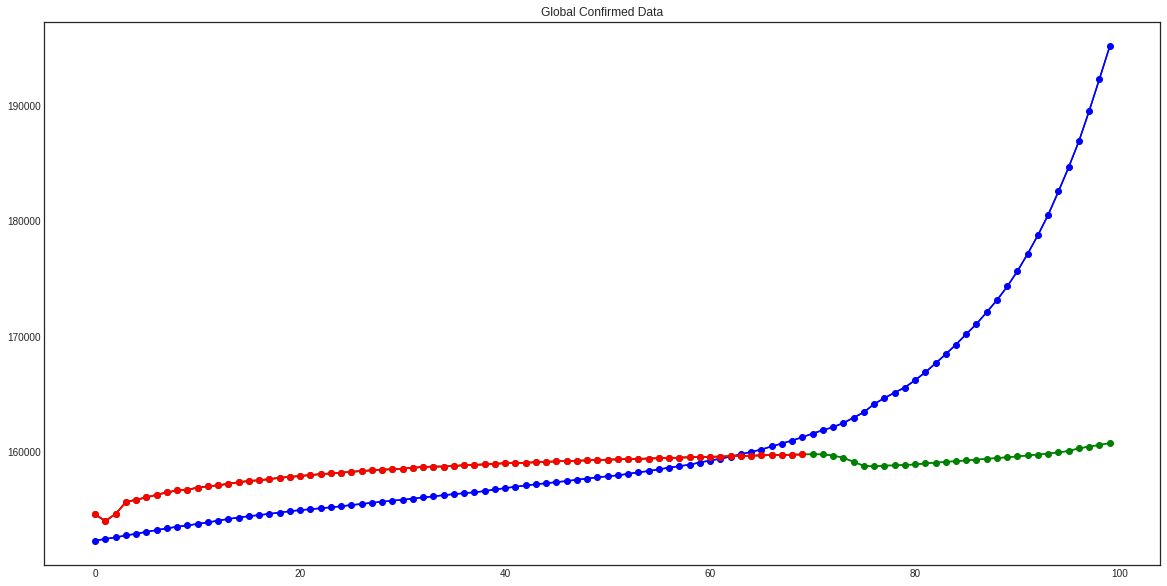

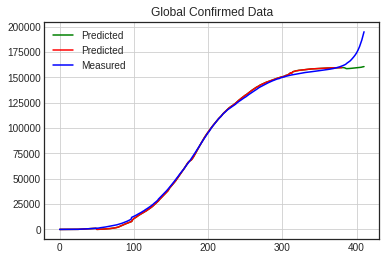

-----------------------------------------------------------------------------------------
| end of epoch 150 | time:  2.79s | mse loss 0.06023 | rmsle loss 0.10634 
-----------------------------------------------------------------------------------------
| epoch 151 |     1/    6 batches | lr 0.000002 | 50.22 ms | loss 0.00158 | ppl     1.00
| epoch 151 |     2/    6 batches | lr 0.000002 | 24.05 ms | loss 0.00127 | ppl     1.00
| epoch 151 |     3/    6 batches | lr 0.000002 | 24.47 ms | loss 0.00138 | ppl     1.00
| epoch 151 |     4/    6 batches | lr 0.000002 | 26.46 ms | loss 0.00087 | ppl     1.00
| epoch 151 |     5/    6 batches | lr 0.000002 | 26.47 ms | loss 0.00105 | ppl     1.00
| epoch 151 |     6/    6 batches | lr 0.000002 | 22.75 ms | loss 0.00158 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 152 |     1/    6 batches | lr 0.000002 | 49.67 ms | loss 0.00167 | ppl     1.00
| epoch 152 |     2/    6 batches | lr 0.000002 | 25.37 ms | loss 0.00106 | ppl     1.00
| epoch 152 |     3/    6 batches | lr 0.000002 | 24.20 ms | loss 0.00129 | ppl     1.00
| epoch 152 |     4/    6 batches | lr 0.000002 | 24.40 ms | loss 0.00071 | ppl     1.00
| epoch 152 |     5/    6 batches | lr 0.000002 | 24.35 ms | loss 0.00104 | ppl     1.00
| epoch 152 |     6/    6 batches | lr 0.000002 | 22.74 ms | loss 0.00199 | ppl     1.00
| epoch 153 |     1/    6 batches | lr 0.000002 | 48.53 ms | loss 0.00205 | ppl     1.00
| epoch 153 |     2/    6 batches | lr 0.000002 | 24.16 ms | loss 0.00128 | ppl     1.00
| epoch 153 |     3/    6 batches | lr 0.000002 | 26.90 ms | loss 0.00147 | ppl     1.00
| epoch 153 |     4/    6 batches | lr 0.000002 | 24.76 ms | loss 0.00075 | ppl     1.00
| epoch 153 |     5/    6 batches | lr 0.000002 | 23.86 ms | loss 0.00097 | ppl     1.00
| epoch 153 |     6/ 

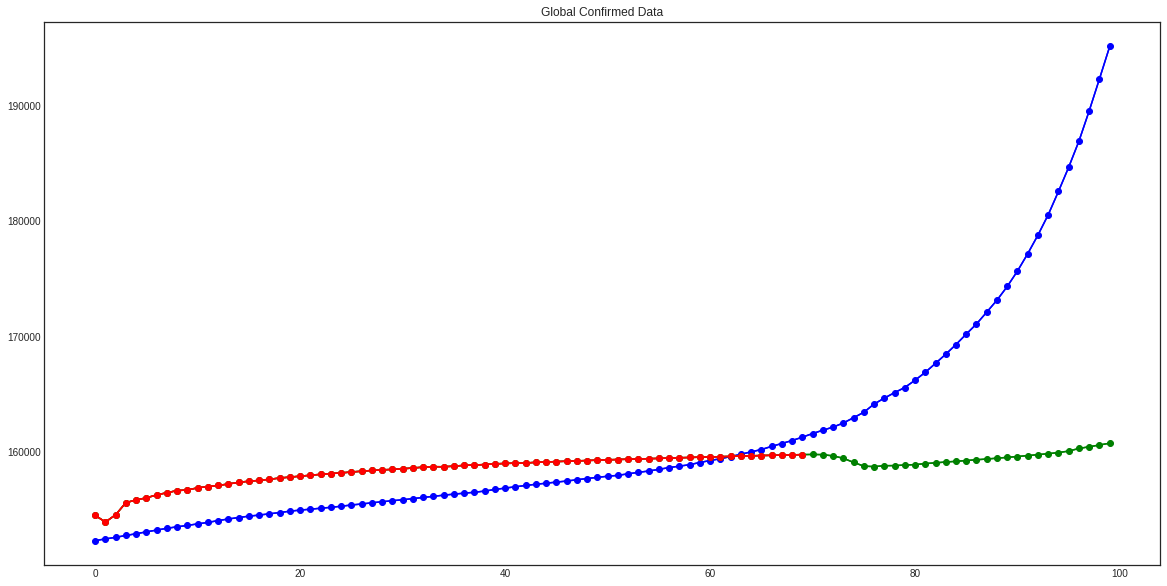

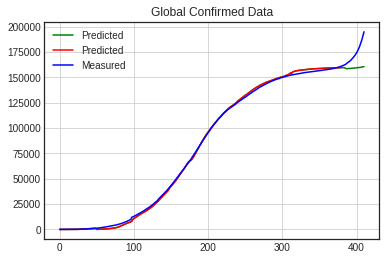

-----------------------------------------------------------------------------------------
| end of epoch 160 | time:  2.81s | mse loss 0.06031 | rmsle loss 0.10642 
-----------------------------------------------------------------------------------------
| epoch 161 |     1/    6 batches | lr 0.000001 | 49.81 ms | loss 0.00189 | ppl     1.00
| epoch 161 |     2/    6 batches | lr 0.000001 | 24.63 ms | loss 0.00119 | ppl     1.00
| epoch 161 |     3/    6 batches | lr 0.000001 | 34.15 ms | loss 0.00175 | ppl     1.00
| epoch 161 |     4/    6 batches | lr 0.000001 | 25.44 ms | loss 0.00063 | ppl     1.00
| epoch 161 |     5/    6 batches | lr 0.000001 | 23.98 ms | loss 0.00096 | ppl     1.00
| epoch 161 |     6/    6 batches | lr 0.000001 | 22.71 ms | loss 0.00142 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 162 |     1/    6 batches | lr 0.000001 | 51.76 ms | loss 0.00190 | ppl     1.00
| epoch 162 |     2/    6 batches | lr 0.000001 | 24.67 ms | loss 0.00095 | ppl     1.00
| epoch 162 |     3/    6 batches | lr 0.000001 | 24.20 ms | loss 0.00123 | ppl     1.00
| epoch 162 |     4/    6 batches | lr 0.000001 | 24.19 ms | loss 0.00070 | ppl     1.00
| epoch 162 |     5/    6 batches | lr 0.000001 | 38.40 ms | loss 0.00104 | ppl     1.00
| epoch 162 |     6/    6 batches | lr 0.000001 | 22.87 ms | loss 0.00179 | ppl     1.00
| epoch 163 |     1/    6 batches | lr 0.000001 | 55.59 ms | loss 0.00209 | ppl     1.00
| epoch 163 |     2/    6 batches | lr 0.000001 | 34.57 ms | loss 0.00118 | ppl     1.00
| epoch 163 |     3/    6 batches | lr 0.000001 | 25.43 ms | loss 0.00210 | ppl     1.00
| epoch 163 |     4/    6 batches | lr 0.000001 | 26.07 ms | loss 0.00079 | ppl     1.00
| epoch 163 |     5/    6 batches | lr 0.000001 | 27.01 ms | loss 0.00083 | ppl     1.00
| epoch 163 |     6/ 

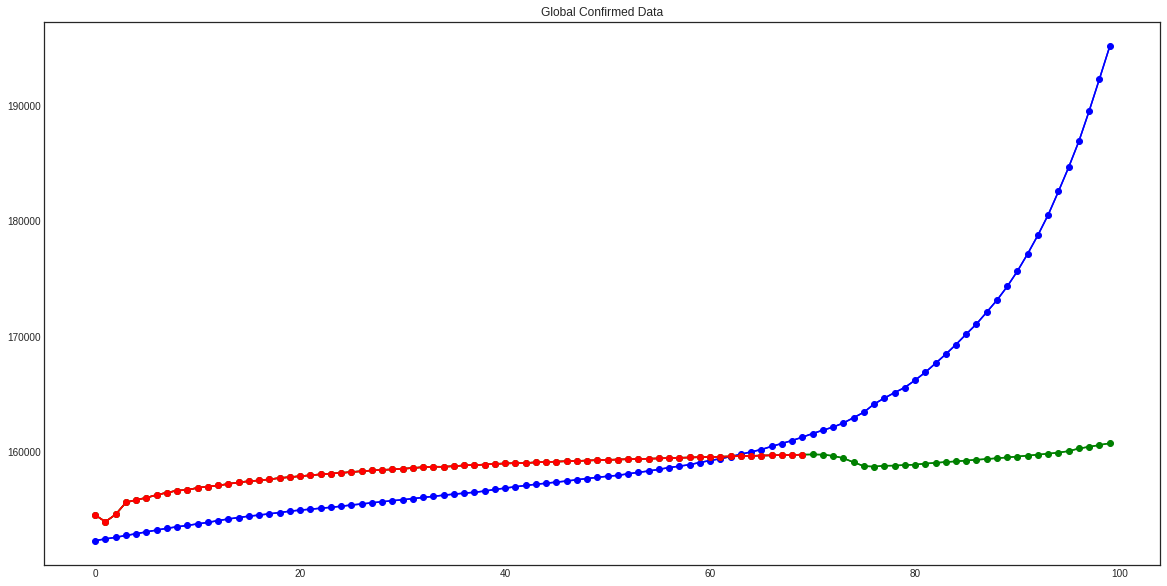

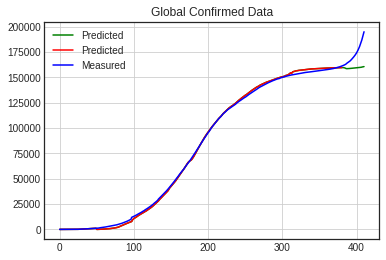

-----------------------------------------------------------------------------------------
| end of epoch 170 | time:  2.82s | mse loss 0.06032 | rmsle loss 0.10643 
-----------------------------------------------------------------------------------------
| epoch 171 |     1/    6 batches | lr 0.000001 | 48.77 ms | loss 0.00185 | ppl     1.00
| epoch 171 |     2/    6 batches | lr 0.000001 | 24.33 ms | loss 0.00134 | ppl     1.00
| epoch 171 |     3/    6 batches | lr 0.000001 | 24.16 ms | loss 0.00177 | ppl     1.00
| epoch 171 |     4/    6 batches | lr 0.000001 | 24.17 ms | loss 0.00077 | ppl     1.00
| epoch 171 |     5/    6 batches | lr 0.000001 | 24.27 ms | loss 0.00113 | ppl     1.00
| epoch 171 |     6/    6 batches | lr 0.000001 | 31.02 ms | loss 0.00182 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 172 |     1/    6 batches | lr 0.000001 | 51.91 ms | loss 0.00152 | ppl     1.00
| epoch 172 |     2/    6 batches | lr 0.000001 | 25.62 ms | loss 0.00129 | ppl     1.00
| epoch 172 |     3/    6 batches | lr 0.000001 | 35.39 ms | loss 0.00127 | ppl     1.00
| epoch 172 |     4/    6 batches | lr 0.000001 | 27.85 ms | loss 0.00090 | ppl     1.00
| epoch 172 |     5/    6 batches | lr 0.000001 | 23.85 ms | loss 0.00105 | ppl     1.00
| epoch 172 |     6/    6 batches | lr 0.000001 | 36.56 ms | loss 0.00141 | ppl     1.00
| epoch 173 |     1/    6 batches | lr 0.000001 | 49.54 ms | loss 0.00181 | ppl     1.00
| epoch 173 |     2/    6 batches | lr 0.000001 | 24.06 ms | loss 0.00093 | ppl     1.00
| epoch 173 |     3/    6 batches | lr 0.000001 | 24.10 ms | loss 0.00158 | ppl     1.00
| epoch 173 |     4/    6 batches | lr 0.000001 | 24.30 ms | loss 0.00066 | ppl     1.00
| epoch 173 |     5/    6 batches | lr 0.000001 | 34.05 ms | loss 0.00082 | ppl     1.00
| epoch 173 |     6/ 

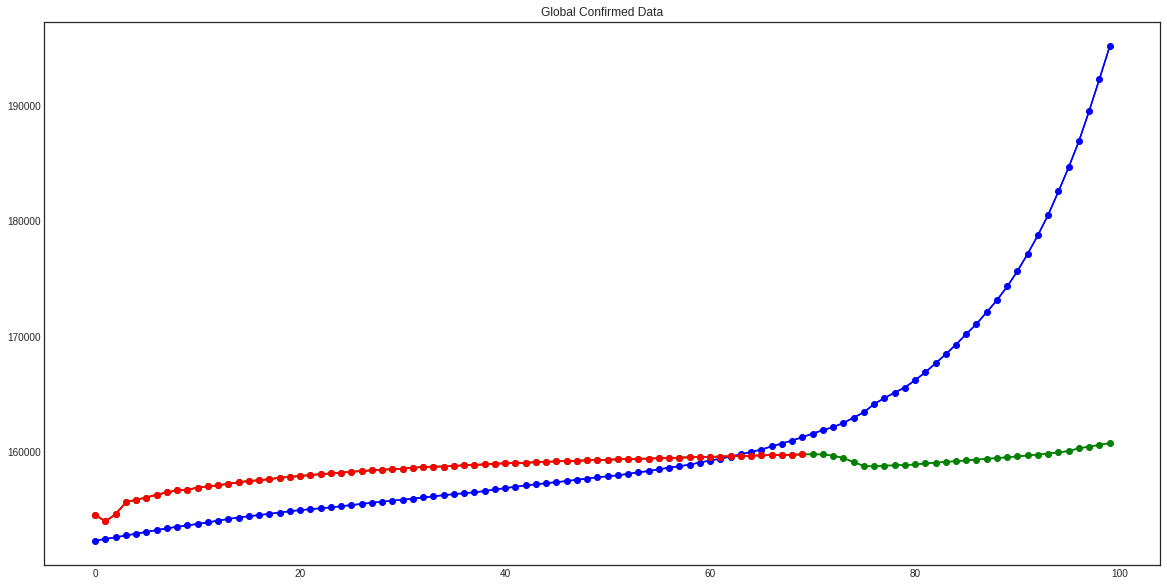

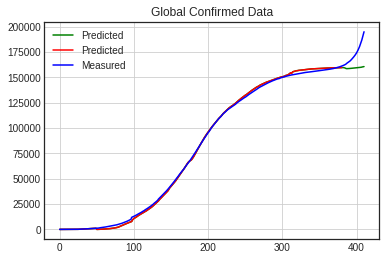

-----------------------------------------------------------------------------------------
| end of epoch 180 | time:  2.83s | mse loss 0.06023 | rmsle loss 0.10634 
-----------------------------------------------------------------------------------------
| epoch 181 |     1/    6 batches | lr 0.000000 | 53.80 ms | loss 0.00165 | ppl     1.00
| epoch 181 |     2/    6 batches | lr 0.000000 | 24.25 ms | loss 0.00127 | ppl     1.00
| epoch 181 |     3/    6 batches | lr 0.000000 | 24.44 ms | loss 0.00121 | ppl     1.00
| epoch 181 |     4/    6 batches | lr 0.000000 | 26.01 ms | loss 0.00055 | ppl     1.00
| epoch 181 |     5/    6 batches | lr 0.000000 | 23.91 ms | loss 0.00083 | ppl     1.00
| epoch 181 |     6/    6 batches | lr 0.000000 | 22.77 ms | loss 0.00147 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 182 |     1/    6 batches | lr 0.000000 | 49.43 ms | loss 0.00207 | ppl     1.00
| epoch 182 |     2/    6 batches | lr 0.000000 | 24.25 ms | loss 0.00153 | ppl     1.00
| epoch 182 |     3/    6 batches | lr 0.000000 | 30.01 ms | loss 0.00170 | ppl     1.00
| epoch 182 |     4/    6 batches | lr 0.000000 | 29.26 ms | loss 0.00066 | ppl     1.00
| epoch 182 |     5/    6 batches | lr 0.000000 | 24.02 ms | loss 0.00074 | ppl     1.00
| epoch 182 |     6/    6 batches | lr 0.000000 | 22.71 ms | loss 0.00197 | ppl     1.00
| epoch 183 |     1/    6 batches | lr 0.000000 | 48.54 ms | loss 0.00154 | ppl     1.00
| epoch 183 |     2/    6 batches | lr 0.000000 | 24.99 ms | loss 0.00149 | ppl     1.00
| epoch 183 |     3/    6 batches | lr 0.000000 | 24.02 ms | loss 0.00125 | ppl     1.00
| epoch 183 |     4/    6 batches | lr 0.000000 | 24.35 ms | loss 0.00083 | ppl     1.00
| epoch 183 |     5/    6 batches | lr 0.000000 | 24.36 ms | loss 0.00082 | ppl     1.00
| epoch 183 |     6/ 

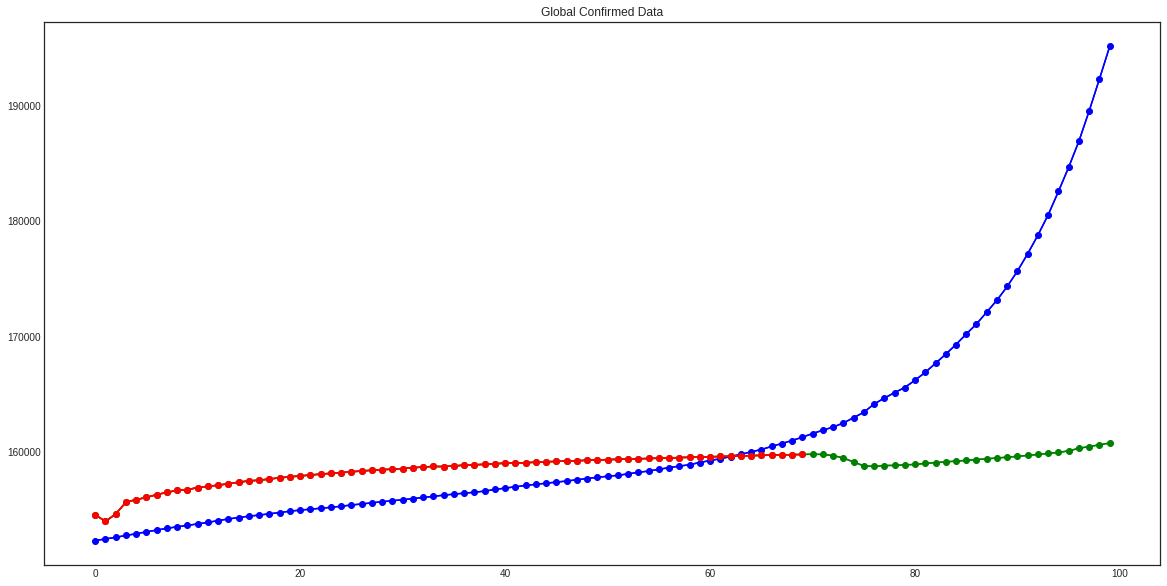

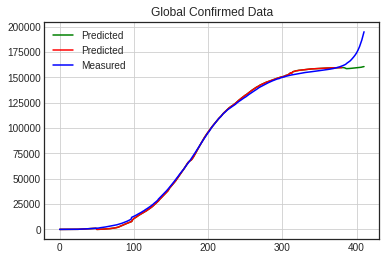

-----------------------------------------------------------------------------------------
| end of epoch 190 | time:  2.83s | mse loss 0.06021 | rmsle loss 0.10632 
-----------------------------------------------------------------------------------------
| epoch 191 |     1/    6 batches | lr 0.000000 | 51.89 ms | loss 0.00162 | ppl     1.00
| epoch 191 |     2/    6 batches | lr 0.000000 | 24.22 ms | loss 0.00118 | ppl     1.00
| epoch 191 |     3/    6 batches | lr 0.000000 | 24.36 ms | loss 0.00173 | ppl     1.00
| epoch 191 |     4/    6 batches | lr 0.000000 | 24.23 ms | loss 0.00064 | ppl     1.00
| epoch 191 |     5/    6 batches | lr 0.000000 | 24.10 ms | loss 0.00090 | ppl     1.00
| epoch 191 |     6/    6 batches | lr 0.000000 | 25.57 ms | loss 0.00184 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 192 |     1/    6 batches | lr 0.000000 | 54.26 ms | loss 0.00208 | ppl     1.00
| epoch 192 |     2/    6 batches | lr 0.000000 | 25.24 ms | loss 0.00095 | ppl     1.00
| epoch 192 |     3/    6 batches | lr 0.000000 | 26.76 ms | loss 0.00141 | ppl     1.00
| epoch 192 |     4/    6 batches | lr 0.000000 | 24.97 ms | loss 0.00058 | ppl     1.00
| epoch 192 |     5/    6 batches | lr 0.000000 | 25.16 ms | loss 0.00107 | ppl     1.00
| epoch 192 |     6/    6 batches | lr 0.000000 | 23.02 ms | loss 0.00185 | ppl     1.00
| epoch 193 |     1/    6 batches | lr 0.000000 | 49.32 ms | loss 0.00184 | ppl     1.00
| epoch 193 |     2/    6 batches | lr 0.000000 | 24.36 ms | loss 0.00117 | ppl     1.00
| epoch 193 |     3/    6 batches | lr 0.000000 | 24.77 ms | loss 0.00156 | ppl     1.00
| epoch 193 |     4/    6 batches | lr 0.000000 | 26.68 ms | loss 0.00069 | ppl     1.00
| epoch 193 |     5/    6 batches | lr 0.000000 | 30.24 ms | loss 0.00103 | ppl     1.00
| epoch 193 |     6/ 

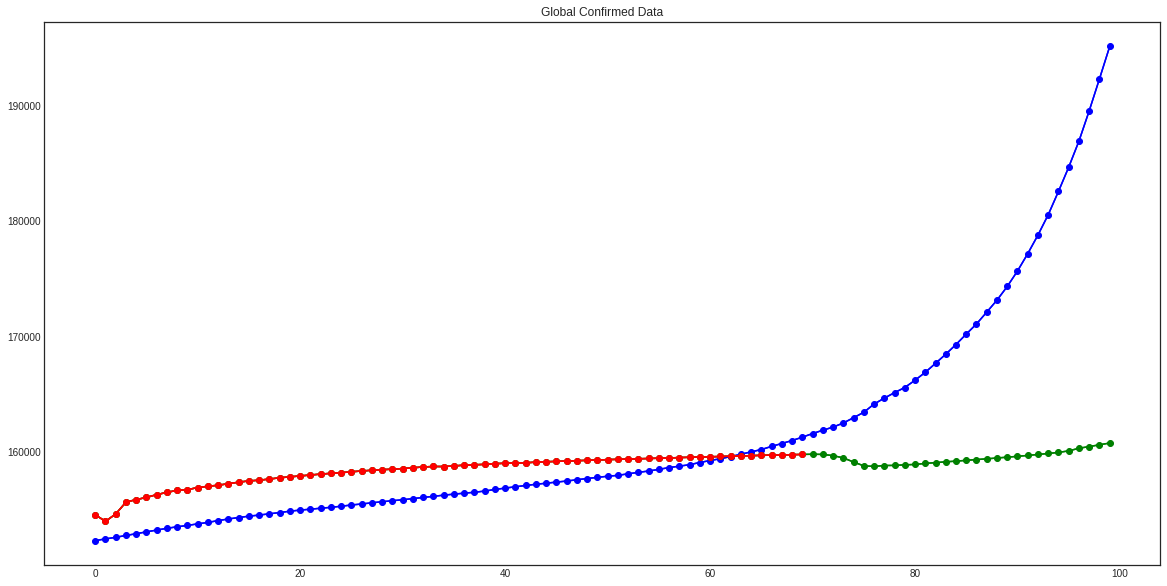

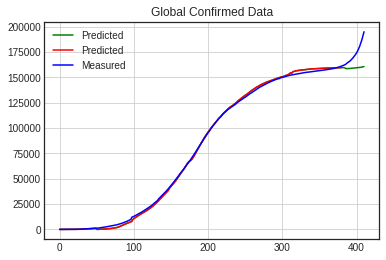

-----------------------------------------------------------------------------------------
| end of epoch 200 | time:  2.81s | mse loss 0.06020 | rmsle loss 0.10632 
-----------------------------------------------------------------------------------------


In [15]:
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/India.csv")
train_data, val_data = dealData.trainTestData()
# train_data = dealData.train_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

best_val_loss = float("inf")
epochs = 200 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if(epoch % 10 is 0):
#         mse, rmsle, truth, test_result = dealData.get_plot_data(model)
#         plot_image(truth, test_result)
        mse, rmsle = dealData.plot_and_loss(model, epoch, True)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | mse loss {:5.5f} | rmsle loss {:5.5f} '.format(epoch, (time.time() - epoch_start_time),
                                         mse, rmsle))
        print('-' * 89)

    scheduler.step() 
#     saveModel(model, "parameter_global_confirmed_50sq_del30_changeLoss_noise_" + str(i) + "_best") 

In [16]:
# saveModel(model, "parameter_india_fatality_50sq_del30_NoGan_best") 

In [117]:
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/japan.csv")

# Load Model

460 460
mse:  0.00059246685
rmsle:  0.00822252
mae:  0.020335464
mape:  0.010466425
rmse:  0.024340643


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



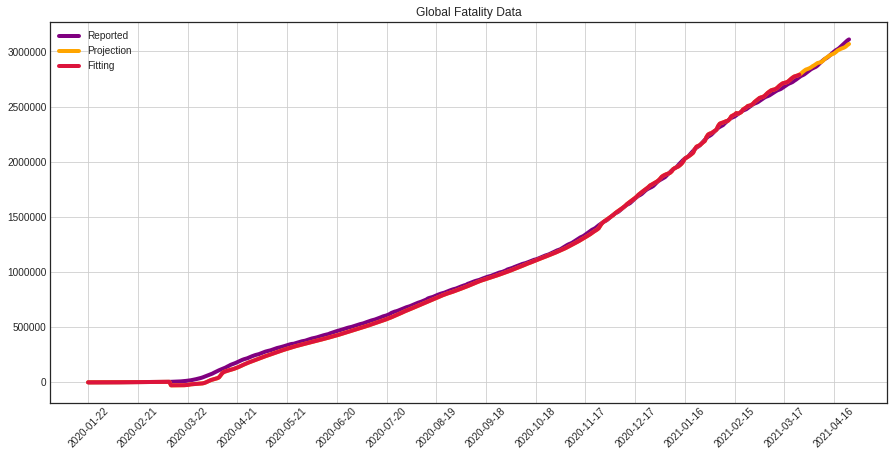

In [5]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_fatality_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_fatality_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Global Fatality Data', isSave = False)



460 460
mse:  0.0047529223
rmsle:  0.023138456
mae:  0.06675628
mape:  0.034516517
rmse:  0.068941444


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



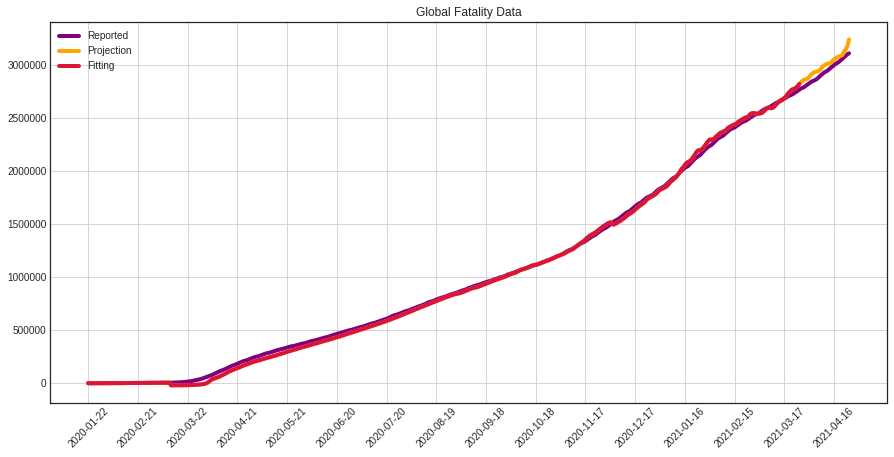

In [6]:
## SJ

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_fatality_50sq_del30_SJ_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_fatality_SJ_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Global Fatality Data', isSave = False)



460 460
mse:  0.054230254
rmsle:  0.08101381
mae:  0.21528275
mape:  0.10875789
rmse:  0.2328739


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



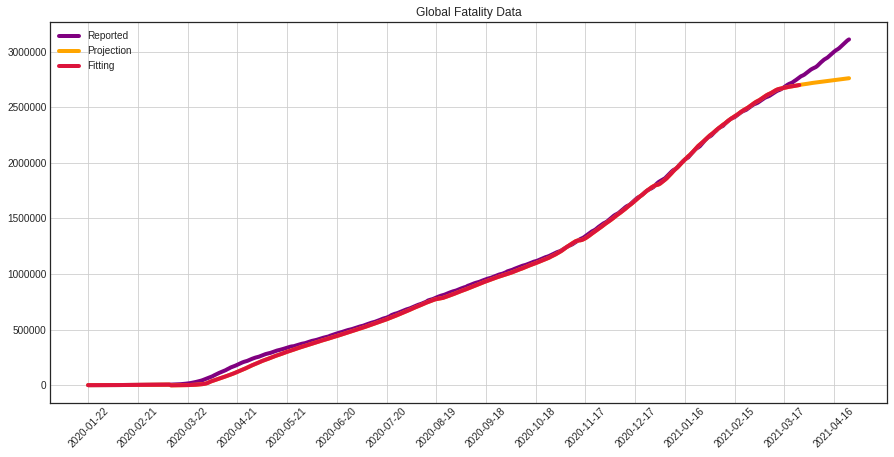

In [7]:
## No Gan

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_fatality_50sq_del30_NoGan_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Global Fatality Data', isSave = False)



# Global

460 460
mse:  0.00059246685
rmsle:  0.00822252
mae:  0.020335464
mape:  0.010466425
rmse:  0.024340643
2020-01-22 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



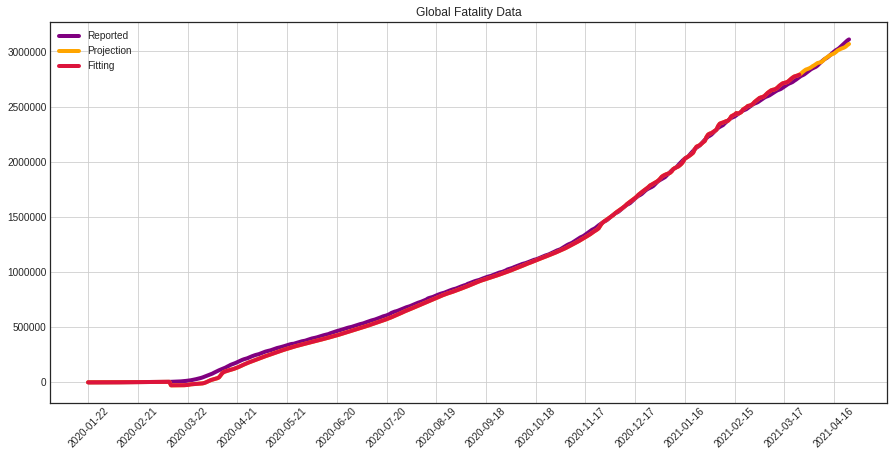

In [8]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_fatality_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_fatality_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Global Fatality Data', isSave = True)

# Us

422 422
mse:  0.0004927347
rmsle:  0.007934245
mae:  0.021051295
mape:  0.01172867
rmse:  0.022197628
2020-02-29 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



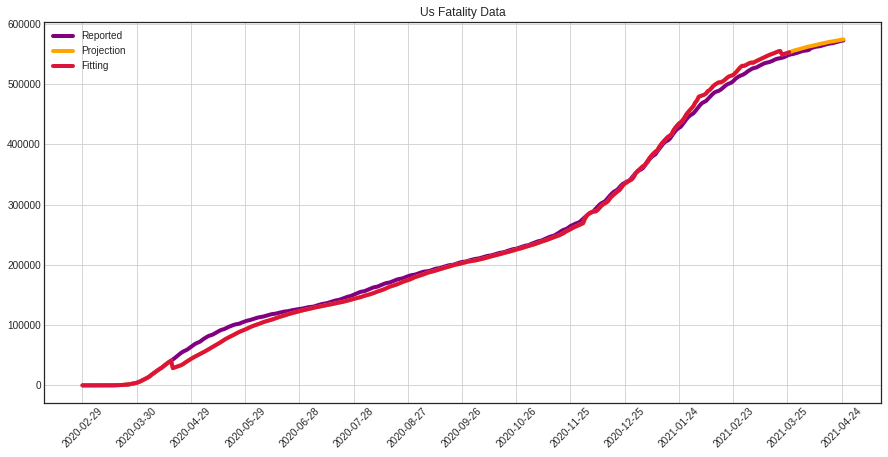

In [9]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_us_fatality_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/us.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_us_del30_fatality_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/us.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Us Fatality Data', isSave = True)

# Japan

438 438
mse:  0.0017123629
rmsle:  0.012491861
mae:  0.031397868
mape:  0.013635153
rmse:  0.041380707
2020-02-13 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



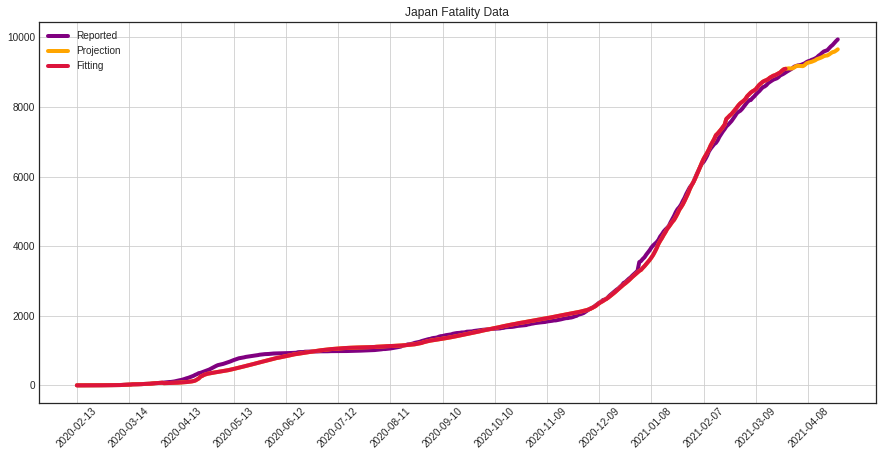

In [10]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_japan_fatality_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/japan.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_japan_del30_fatality_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/japan.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Japan Fatality Data', isSave = True)

# Spain

419 419
mse:  0.00029874372
rmsle:  0.006227438
mae:  0.013127872
mape:  0.007401102
rmse:  0.017284205
2020-03-03 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



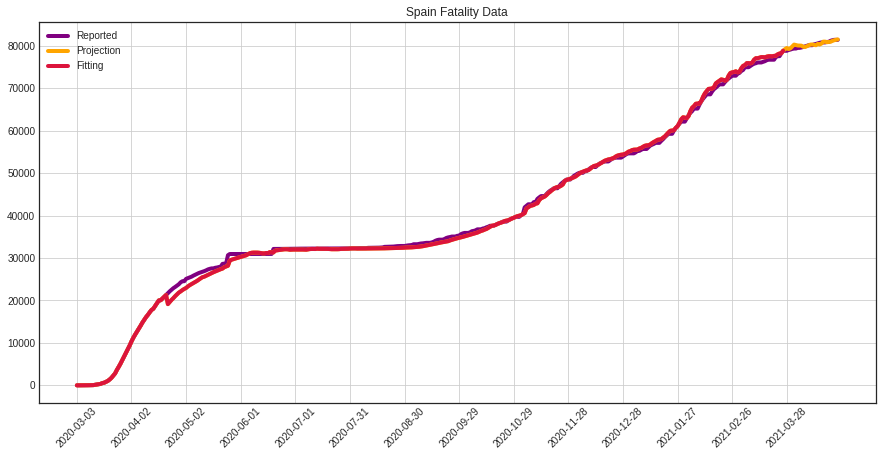

In [11]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_spain_fatality_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/spain.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_spain_del30_fatality_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/spain.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Spain Fatality Data', isSave = True)

# France

436 436
mse:  0.0010536112
rmsle:  0.0113304565
mae:  0.029016519
mape:  0.015564527
rmse:  0.03245938
2020-02-15 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



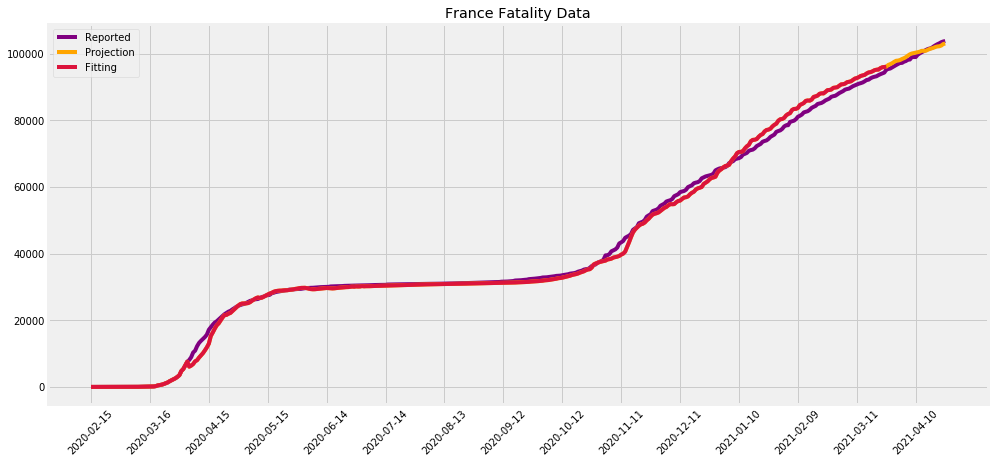

In [33]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_france_fatality_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/france.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_france_del30_fatality_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/france.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'France Fatality Data', isSave = True)

# Italy

430 430
mse:  0.007078091
rmsle:  0.02867875
mae:  0.0799668
mape:  0.04176528
rmse:  0.08413139
2020-02-21 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



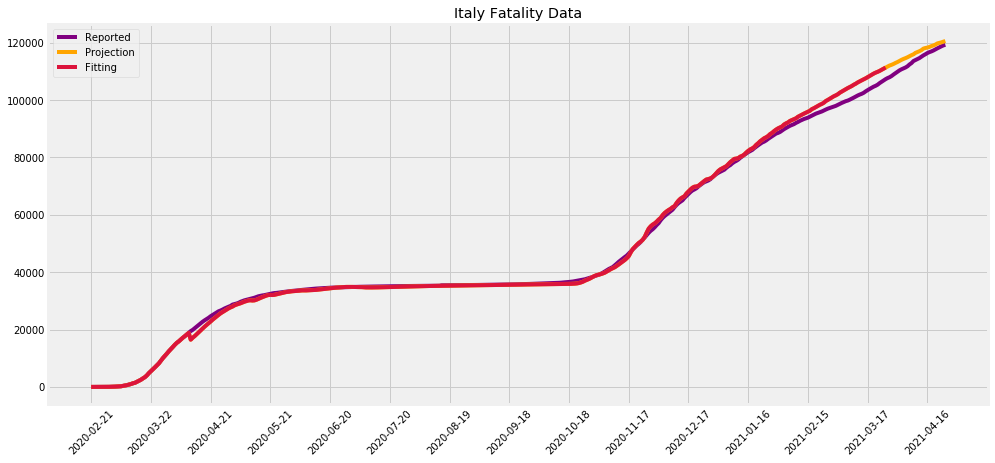

In [34]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_italy_fatality_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/italy.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_italy_del30_fatality_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/italy.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Italy Fatality Data', isSave = True)